In [1]:
from eaaw_graphlime_utils import *
from config import *
from prune_and_fine_tune_utils import *
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import matplotlib.pyplot as plt
import random
import pickle
from scipy import stats
from scipy.stats import anderson, kstest, zscore, shapiro
import matplotlib as mpl

mpl.rcParams['figure.dpi']=250

root_folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2'
training_folder = os.path.join(root_folder,'training_results')

In [2]:
import os
import torch
import random
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


from torch_geometric.nn import GATConv, GCNConv, GraphConv, SAGEConv, GINConv, global_mean_pool
from torch.nn import ModuleList
from   pcgrad.pcgrad import PCGrad 



def create_dataset_from_files(root, dataset_name):
    # Load raw files
    edges = pd.read_csv(os.path.join(root, f"{dataset_name}_A.txt"), header=None, sep=",")
    graph_indicator = pd.read_csv(os.path.join(root, f"{dataset_name}_graph_indicator.txt"), header=None)
    graph_labels = pd.read_csv(os.path.join(root, f"{dataset_name}_graph_labels.txt"), header=None)
    node_labels = pd.read_csv(os.path.join(root, f"{dataset_name}_node_labels.txt"), header=None)

    data_list = []
    N = graph_labels.shape[0]  # Number of graphs in the dataset
    indices_to_use = range(1, N + 1)  # Graph indices start from 1


    # Process each graph
    for c, i in enumerate(indices_to_use):
        
        # Find nodes belonging to the current graph
        node_indices = graph_indicator[graph_indicator[0] == i].index

        # Map global node indices to local indices
        node_idx_map = {idx: j for j, idx in enumerate(node_indices)}
        graph_edges = edges[edges[0].isin(node_indices + 1) & edges[1].isin(node_indices + 1)]
        # graph_edges = graph_edges.applymap(lambda x: node_idx_map[x - 1])
        graph_edges = graph_edges.apply(lambda col: col.map(lambda x: node_idx_map[x - 1]))
        edge_index = torch.tensor(graph_edges.values, dtype=torch.long).t().contiguous()

        x = torch.tensor(node_labels.iloc[node_indices].values).squeeze()
        num_classes = node_labels[0].max() + 1 
        x = F.one_hot(x.clone().detach().long(), num_classes=num_classes).float() 
        y = torch.tensor(graph_labels.iloc[i - 1].values, dtype=torch.long)
        y = (y + 1) // 2  # Transform [-1, 1] -> [0, 1]
        # Create a Data object for the current graph
        data = Data(x=x, edge_index=edge_index, y=y)
        data.original_index = c
        data_list.append(data)

    return data_list


def split_dataset(data_list, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    # Ensure ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # Set random seed for reproducibility
    random.seed(seed)

    # Shuffle indices
    indices = list(range(len(data_list)))
    random.shuffle(indices)

    # Split indices
    train_end = int(train_ratio * len(indices))
    val_end = train_end + int(val_ratio * len(indices))
    
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Create subsets
    train_data = [data_list[i] for i in train_indices]
    val_data = [data_list[i] for i in val_indices]
    test_data = [data_list[i] for i in test_indices]

    return train_data, val_data, test_data


def generate_subgraph_graph_clf(data, subgraph_size=5,seed=0):
    data = data.clone()
    torch.manual_seed(seed)
    random.seed(seed)
    num_nodes = data.x.shape[0]
    subgraph_node_idx = torch.tensor(random.sample(list(range(num_nodes)), min(subgraph_size, num_nodes)))
    sub_edge_index, _ = subgraph(subgraph_node_idx, data.edge_index, relabel_nodes=True, num_nodes=num_nodes)
    data_sub = Data(
        x=data.x[subgraph_node_idx] if data.x is not None else None,
        edge_index=sub_edge_index,
        y=data.y)
    del sub_edge_index
    subgraph_signature = '_'.join([str(s) for s in subgraph_node_idx.tolist()])
    subgraph_signature = str(data.original_index) + '_' + subgraph_signature
    return data_sub, subgraph_signature, subgraph_node_idx



def build_subgraph_collections(train_data, num_collections, num_subgraphs_per_collection, subgraph_size, proportion_features_to_watermark, aggregate_method='flatten',seed=0):
    random.seed(seed)
    assert aggregate_method in ['flatten','average','sum']
    subgraph_collection_dict = {i:{'subgraphs':{},'feature_matrix':None} for i in range(num_collections)}
    graphs_used = []
    for i in range(num_collections):
        graph_indices = random.sample(list(range(len(train_data))),num_subgraphs_per_collection)
        graph_indices_original = [train_data[i].original_index for i in graph_indices]
        graphs_used.extend(graph_indices_original)
        graph_features = []
        for idx in graph_indices:
            graph = train_data[idx]
            this_subgraph, subgraph_signature, _ =  generate_subgraph_graph_clf(graph, subgraph_size=subgraph_size,seed=seed)
            subgraph_collection_dict[i]['subgraphs'][subgraph_signature]=this_subgraph
            if aggregate_method=='flatten':
                graph_features.append(this_subgraph.x.flatten().tolist()) # average node features
            elif aggregate_method=='average':
                graph_features.append(torch.mean(this_subgraph.x,dim=0).tolist()) # average node features
            elif aggregate_method=='sum':
                graph_features.append(torch.sum(this_subgraph.x,dim=0).tolist()) # average node features
        graph_features = torch.tensor(graph_features)
        subgraph_collection_dict[i]['feature_matrix']=graph_features



    subgraph_collection_features_concat = torch.vstack([subgraph_collection_dict[k]['feature_matrix'] for k in subgraph_collection_dict.keys()])
    nonzero_feat_mask = subgraph_collection_features_concat!=0
    nonzero_feat_counts = torch.sum(nonzero_feat_mask,dim=0)
    sorted_indices = torch.argsort(nonzero_feat_counts, descending=True)
    len_watermark = int(np.floor(proportion_features_to_watermark*len(sorted_indices)))
    most_represented_indices = sorted_indices[:len_watermark]


    watermarks = create_watermarks_at_most_represented_indices(num_collections, len_watermark, subgraph_collection_features_concat.shape[1], most_represented_indices, seed)
    for (k,wmk) in zip(subgraph_collection_dict.keys(),watermarks):
        subgraph_collection_dict[k]['watermark']=wmk
    return subgraph_collection_dict, most_represented_indices, list(set(graphs_used))


def regress_on_subgraph_collections(model, subgraph_collection_dict, collection_id, mode='train'):
    collection = subgraph_collection_dict[collection_id]
    betas = []
    for subgraph_signature in collection.keys():
        subgraph = collection['subgraphs'][subgraph_signature]
        x_sub = collection['feature_matrix']
        y_sub = model(subgraph, mode)
        beta = solve_regression(x_sub,y_sub)
        betas.append(beta)
    return betas

class graph_clf_model(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, hidden_channels, dropout, conv_fn):
        super(graph_clf_model, self).__init__()
        self.layers = ModuleList([conv_fn(num_node_features, hidden_channels)])
        self.layers += [conv_fn(hidden_channels,hidden_channels)]*(num_layers-2)
        self.layers += [conv_fn(hidden_channels,num_classes)]
        self.dropout= dropout

    def forward(self, x, edge_index, batch=None):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = torch.nn.Dropout(p=self.dropout)(x)

        x = self.layers[-1](x, edge_index)
        
        # Pool node embeddings into graph-level embeddings
        x = global_mean_pool(x, batch)  # Shape: [num_graphs, num_classes]
        return F.log_softmax(x, dim=1)
        # return x

def collect_random_subgraphs_MUTAG(dataset, subgraph_size, num_graphs):
    subgraph_list = []
    for _ in range(num_graphs):
        graph_index = random.choice(range(len(dataset)))
        data = dataset[graph_index]
        num_nodes = data.x.shape[0]
        subgraph_node_idx = torch.tensor(random.sample(list(range(num_nodes)), min(subgraph_size, num_nodes)))
        sub_edge_index, _ = subgraph(subgraph_node_idx, data.edge_index, relabel_nodes=True, num_nodes=num_nodes)
        data_sub = Data(
            x=data.x[subgraph_node_idx] if data.x is not None else None,
            edge_index=sub_edge_index,
            y=data.y)
        subgraph_list.append(data_sub)
    return subgraph_list




In [ ]:

def train_with_watermark(coefWmk, conv_fn, hidden_channels, dropout, lr, use_pcgrad, epochs, proportion_features_to_watermark,regression_lambda,epsilon,num_collections,num_subgraphs_per_collection,subgraph_size,aggregate_method,batch_size,seed):
    data_list = create_dataset_from_files(f"../data/{dataset_name}_raw", dataset_name)
    train_data, val_data, test_data = split_dataset(data_list, train_ratio=train_ratio, val_ratio=val_ratio, test_ratio=test_ratio)
    val_loader = DataLoader(train_data, batch_size=500, shuffle=True)
    test_loader = DataLoader(train_data, batch_size=500, shuffle=True)
    model =  graph_clf_model(num_node_features, num_classes, num_layers, hidden_channels, dropout, conv_fn)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_pcgrad==True:
        optimizer = PCGrad(optimizer)

    subgraph_collection_dict, most_represented_indices, graphs_used = build_subgraph_collections(train_data, num_collections, num_subgraphs_per_collection, subgraph_size, proportion_features_to_watermark, aggregate_method, seed)
    print("most_represented_indices:",most_represented_indices)
    print('wmk:',subgraph_collection_dict[list(subgraph_collection_dict.keys())[0]]['watermark'])
    train_data = [d for d in train_data if d.original_index not in graphs_used]
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    primary_loss_curve, watermark_loss_curve = [],[]
    observed_matches = []
    for e in range(epochs):
        optimizer.zero_grad()

        loss_primary, loss_watermark = torch.tensor(0.0), torch.tensor(0.0)
        train_accuracies, val_accuracies = torch.tensor([]), torch.tensor([])
        raw_betas = []
        watermark_alignment_rates = []
        model.train()
        for batch in train_loader:
            log_logits_train  = model(batch.x, batch.edge_index, batch=batch.batch)
            loss_primary  += F.nll_loss(log_logits_train, batch.y)
            train_accuracies = torch.cat((train_accuracies, accuracy(log_logits_train, batch.y).unsqueeze(dim=0)), dim=0)

        for k in subgraph_collection_dict.keys():
            this_collection = subgraph_collection_dict[k]
            this_watermark = this_collection['watermark']
            # print('this_watermark:',this_watermark)
            x_sub = this_collection['feature_matrix']
            y_sub = []
            for subgraph_ in this_collection['subgraphs'].values():
                y_sub.append(model(subgraph_.x, subgraph_.edge_index))
            y_sub = torch.vstack(y_sub)
            omit_indices,not_omit_indices = get_omit_indices(x_sub, this_watermark,ignore_zeros_from_subgraphs=False)
            # print('nonzero:',sum(not_omit_indices))
            this_raw_beta = solve_regression(x_sub, y_sub, regression_lambda)
            raw_betas.append(this_raw_beta)
            beta          = process_beta(this_raw_beta, omit_indices)
            B_x_W = (beta*this_watermark).clone()
            B_x_W = B_x_W[not_omit_indices]
            # watermark_alignment_rates.append(torch.mean(
            sign_beta_most_rep = torch.sign(beta)[most_represented_indices]
            wmk_most_rep = this_watermark[most_represented_indices]
            watermark_alignment_rates.append(torch.sum(torch.eq(sign_beta_most_rep, wmk_most_rep)).item()/len(most_represented_indices))
            beta_weights = torch.ones(len(not_omit_indices))#beta_weights[not_omit_indices]
            loss_watermark += torch.mean(torch.clamp(epsilon-B_x_W, min=0)*beta_weights)

        model.eval()
        for batch in val_loader:
            log_logits_val  = model(batch.x, batch.edge_index, batch=batch.batch)
            val_accuracies = torch.cat((val_accuracies, accuracy(log_logits_val, batch.y).unsqueeze(dim=0)), dim=0)

        stacked_sign_betas= torch.sign(torch.vstack(raw_betas))
        # print('stacked_sign_betas_not_wmk:',stacked_sign_betas_not_wmk)
        match_count_with_zeros = count_matches(stacked_sign_betas, ignore_zeros=False)
        match_count_without_zeros = count_matches(stacked_sign_betas, ignore_zeros=True)

        observed_matches.append(match_count_without_zeros)

        acc_trn = torch.mean(train_accuracies).item()
        acc_val = torch.mean(val_accuracies).item()
        avg_wmk_alignment = np.mean(watermark_alignment_rates)
        loss = loss_primary + coefWmk*loss_watermark
        primary_loss_curve.append(loss_primary.item())
        watermark_loss_curve.append(coefWmk*loss_watermark.item())
        loss.backward()
        optimizer.step()
        # epoch_printout = f'Epoch: {epoch:3d}, L (clf/wmk) = {loss_primary:.3f}/{loss_watermark:.3f}, acc (trn/val/test)= {acc_trn:.3f}/{acc_val:.3f}/{acc_test:.3f}, #_match_WMK w/wout 0s = {match_count_with_zeros}/{match_count_without_zeros}, conf w/wout 0s = {confidence_with_zeros:.3f}/{confidence_without_zeros:.3f}, #_match_NOT_WMK w/wout 0s = {match_count_not_wmk_with_zeros}/{match_count_not_wmk_without_zeros}, conf w/wout 0s= {confidence_not_wmk_with_zeros:.3f}/{confidence_not_wmk_without_zeros:.3f}' + additional_content
        if e%10==0:
            epoch_printout = f'Epoch: {e:3d}, L (clf/wmk) = {loss_primary:.3f}/{coefWmk*loss_watermark:.3f}, acc (trn/val)= {acc_trn:.3f}/{acc_val:.3f}, #_match_WMK w/wout 0s = {match_count_with_zeros}/{match_count_without_zeros}, alignment={avg_wmk_alignment:.3f}'
            print(epoch_printout)
    test_accuracies = torch.tensor([])
    for batch in test_loader:
        log_logits_test  = model(batch.x, batch.edge_index, batch=batch.batch)
        test_accuracies = torch.cat((test_accuracies, accuracy(log_logits_test, batch.y).unsqueeze(dim=0)), dim=0)
    epoch_printout = f'Epoch: {e:3d}, L (clf/wmk) = {loss_primary:.3f}/{coefWmk*loss_watermark:.3f}, acc (trn/val)= {acc_trn:.3f}/{acc_val:.3f}, #_match_WMK w/wout 0s = {match_count_with_zeros}/{match_count_without_zeros}, alignment={avg_wmk_alignment:.3f}'
    print(epoch_printout)
    print(f'Test accuracy: {torch.mean(test_accuracies).item():.3f}')

    final_observed_match_count = np.mean(observed_matches[-5:])
    MUTAG_data_list = create_dataset_from_files(f"../data/MUTAG_raw", 'MUTAG')
    random_subgraph_list = collect_random_subgraphs_MUTAG(MUTAG_data_list, subgraph_size, 200)
    all_match_counts = []
    for i in range(num_iter):
        print(f'{i}/{num_iter}',end='\r')
        betas = []
        for c in range(num_collections):
            subgraph_choices = random.sample(range(len(random_subgraph_list)),num_subgraphs_per_collection)
            subgraphs_ = [random_subgraph_list[idx] for idx in subgraph_choices]
            y_subs = torch.vstack([model(s.x, s.edge_index) for s in subgraphs_])
            x_subs = torch.tensor([get_x(s) for s in subgraphs_])
            this_raw_beta = solve_regression(x_subs, y_subs, regression_lambda)
            betas.append(torch.sign(this_raw_beta))
        betas = torch.vstack(betas)
        all_match_counts.append(count_matches(betas,ignore_zeros=True))
    mu = np.mean(all_match_counts)
    sig = np.std(all_match_counts)
    print('observed_matches[-5:]:',observed_matches[-5:])
    print('average final observed match:',final_observed_match_count)
    print(f'Naturally-occurring match counts (mu,sig): ({mu},{sig})')
    z = (final_observed_match_count-mu)/sig
    p = scipy.stats.norm.sf(z)
    print('p_value:',p)
    

    root_ = f'../MUTAG_results/{num_collections}_collections_{num_subgraphs_per_collection}_subgraphs_size_{subgraph_size}_coefWmk{coefWmk}_numLayers{num_layers}_hiddenDim{hidden_channels}_epsilon{epsilon}_dropout{dropout}_lr{lr}'
    try:
        os.mkdir(root_)
    except:
        pass
    root_ += f'/seed{seed}'
    try:
        os.mkdir(root_)
    except:
        pass
    with open(os.path.join(root_,'all_match_counts.pkl'),'wb') as f:
        pickle.dump(all_match_counts,f)
    with open(os.path.join(root_,f'model.pkl'),'wb') as f:
        pickle.dump(model,f)
    with open(os.path.join(root_,f'acc_trn.pkl'),'wb') as f:
        pickle.dump(acc_trn,f)
    with open(os.path.join(root_,f'acc_val.pkl'),'wb') as f:
        pickle.dump(acc_val,f)
    return model, subgraph_collection_dict, primary_loss_curve, watermark_loss_curve, mu, sig, p

num_collections = 5
num_subgraphs_per_collection = 5
subgraph_size = 10
dataset_name='MUTAG'
root = f"../data/{dataset_name}_raw"  # Path to raw files
seed=0
train_ratio, test_ratio, val_ratio = 0.7, 0.15, 0.15
random.seed(seed)



num_node_features = data_list[0].x.shape[1]
num_classes=2
num_layers=4
hidden_channels=64
dropout=0
lr=0.001
use_pcgrad=True
epochs=4000
proportion_features_to_watermark=1
regression_lambda=0.01
epsilon=0.01
coefWmk=80
aggregate_method='average'
#GATConv, GCNConv, GraphConv, SAGEConv, GINConv, global_mean_pool
conv_fn=GraphConv
batch_size=10

num_iter=1000
num_collections = 5
num_subgraphs_per_collection = 5
subgraph_size = 10
aggregate_method='average'
if aggregate_method=='flatten':
    get_x = lambda sub: sub.x.flatten().tolist()
elif aggregate_method=='average':
    get_x = lambda sub: torch.mean(sub.x, dim=0).tolist()
elif aggregate_method=='sum':
    get_x = lambda sub: torch.sum(sub.x, dim=0).tolist()


for subgraph_size in [10,20]:
    for num_collections in [2,3,4,5,6]:
        for seed in range(5):
            model, subgraph_collection_dict, primary_loss_curve, watermark_loss_curve, mu, sig, p = train_with_watermark(coefWmk, conv_fn, hidden_channels, dropout, lr, use_pcgrad, epochs, proportion_features_to_watermark,regression_lambda,epsilon,num_collections,num_subgraphs_per_collection,subgraph_size,aggregate_method,batch_size,seed)

            plt.plot(primary_loss_curve)
            plt.plot(watermark_loss_curve)
            plt.title(f'{num_collections} collections of {num_subgraphs_per_collection} subgraphs, size {subgraph_size}\nseed={seed}\nmu={mu},sig={sig},p={p}')
            plt.show()

In [ ]:
## Test Matches for Normality

photo_train_dir = os.path.join(root_dir,'training_results','photo')
photo_arch_dir_SAGE = photo_train_dir + '/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue'
photo_arch_dir_SGC  = photo_train_dir + '/archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue'
photo_arch_dir_GCN  = photo_train_dir + '/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue'
get_photo_model = lambda x,y: f'/{x}pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs{y}_eps0.01_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_coefWmk100_pcgrad_regressionLambda0.1'
photo_models_SAGE = [photo_arch_dir_SAGE + get_photo_model(p,n) for (p,n) in zip([14.36],[4])]
photo_models_SGC = [photo_arch_dir_SGC + get_photo_model(p,n) for (p,n) in zip([14.36],[4])]
photo_models_GCN = [photo_arch_dir_GCN + get_photo_model(p,n) for (p,n) in zip([14.36],[4])]

CS_train_dir = os.path.join(root_dir,'training_results','CS')
CS_arch_dir_SAGE = CS_train_dir + '/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue'
CS_arch_dir_SGC  = CS_train_dir + '/archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue'
CS_arch_dir_GCN  = CS_train_dir + '/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue'
get_CS_model = lambda x,y: f'/{x}pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs{y}_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_pcgrad_regressionLambda0.1'
CS_models_SAGE = [CS_arch_dir_SAGE + get_CS_model(p,n) for (p,n) in zip([4.47],[4])]
CS_models_SGC = [CS_arch_dir_SGC + get_CS_model(p,n) for (p,n) in zip([4.47],[4])]
CS_models_GCN = [CS_arch_dir_GCN + get_CS_model(p,n) for (p,n) in zip([4.47],[4])]


PubMed_train_dir = os.path.join(root_dir,'training_results','PubMed')
PubMed_arch_dir_SAGE = PubMed_train_dir + '/archSAGE_elu_nLayers3_hDim512_drop0.95_skipTrue'
PubMed_arch_dir_SGC  = PubMed_train_dir + '/archSGC_elu_nLayers3_hDim512_drop0.8_skipTrue'
PubMed_arch_dir_GCN  = PubMed_train_dir + '/archGCN_elu_nLayers3_hDim512_drop0.8_skipTrue'
get_PubMed_model_SAGE = lambda x,y: f'/{x}pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs{y}_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.005_epochs200_coefWmk2.4_pcgrad_regressionLambda0.1'
get_PubMed_model_others = lambda x,y: f'/{x}pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs{y}_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.005_epochs200_coefWmk5.0_pcgrad_regressionLambda0.1'
PubMed_models_SAGE = [PubMed_arch_dir_SAGE + get_PubMed_model_SAGE(p,n) for (p,n) in  zip([17.6],[4])]
PubMed_models_SGC = [PubMed_arch_dir_SGC + get_PubMed_model_others(p,n) for (p,n) in  zip([17.6],[4])]
PubMed_models_GCN = [PubMed_arch_dir_GCN + get_PubMed_model_others(p,n) for (p,n) in  zip([17.6],[4])]

num_bootstraps = 50

all_models_photo = [photo_models_SAGE,photo_models_SGC,photo_models_GCN]
all_models_CS = [CS_models_SAGE,CS_models_SGC,CS_models_GCN]
all_models_PubMed = [PubMed_models_SAGE,PubMed_models_SGC,PubMed_models_GCN]
model_names = ['SAGE','SGC','GCN']
datasets = ['photo','CS','PubMed']
for i, models_ in enumerate([all_models_photo,all_models_CS,all_models_PubMed]):
    dataset_name = datasets[i]
    for models, model_name in zip(models_,['SAGE','SGC','GCN']):
        shapiro_stats, shapiro_ps = [],[]
        anderson_stats, anderson_crits = [],[]
        ks_test_stats, ks_stat_ps = [],[]
        for model in models:
            seeds = [s for s in os.listdir(model) if s[:4]=='seed']
            for s in seeds:
                current_path = os.path.join(model,s,'all_match_counts.pkl')
                match_counts = pickle.load(open(current_path,'rb'))
                for _ in range(num_bootstraps):
                    resample = np.random.choice(match_counts, size=len(match_counts)//5, replace=True)
                    shapiro_results = shapiro(resample)
                    shapiro_stats.append(shapiro_results[0])
                    shapiro_ps.append(shapiro_results[1])
                    anderson_result = anderson(resample, dist='norm')
                    anderson_stats.append(anderson_result.statistic)
                    anderson_crits.append(anderson_result.critical_values[2])
                    standardized_data = zscore(resample)
                    ks_results = kstest(standardized_data, 'norm')
                    ks_test_stats.append(ks_results[0])
                    ks_stat_ps.append(ks_results[1])
        print(f'Average {dataset_name} {model_name} results: Shapiro (stat, p)=({np.mean(shapiro_stats):.3f},{np.mean(shapiro_ps):.3f}) -- Anderson (stat,critical val 5%)=({np.mean(anderson_stats):.3f},{np.mean(anderson_crits):.3f}) -- KS_Test (stats, p)=({np.mean(ks_test_stats):.3f},{np.mean(ks_stat_ps):.3f})')





Average photo SAGE results: Shapiro (stat, p)=(0.990,0.317) -- Anderson (stat,critical val 5%)=(0.570,0.772) -- KS_Test (stats, p)=(0.061,0.468)
Average photo SGC results: Shapiro (stat, p)=(0.990,0.304) -- Anderson (stat,critical val 5%)=(0.560,0.772) -- KS_Test (stats, p)=(0.060,0.490)
Average photo GCN results: Shapiro (stat, p)=(0.991,0.332) -- Anderson (stat,critical val 5%)=(0.527,0.772) -- KS_Test (stats, p)=(0.059,0.505)
Average CS SAGE results: Shapiro (stat, p)=(0.990,0.283) -- Anderson (stat,critical val 5%)=(0.555,0.772) -- KS_Test (stats, p)=(0.060,0.474)
Average CS SGC results: Shapiro (stat, p)=(0.989,0.258) -- Anderson (stat,critical val 5%)=(0.695,0.772) -- KS_Test (stats, p)=(0.065,0.405)
Average CS GCN results: Shapiro (stat, p)=(0.988,0.210) -- Anderson (stat,critical val 5%)=(0.672,0.772) -- KS_Test (stats, p)=(0.065,0.400)
Average PubMed SAGE results: Shapiro (stat, p)=(0.989,0.225) -- Anderson (stat,critical val 5%)=(0.631,0.772) -- KS_Test (stats, p)=(0.064,0.40

In [33]:
0.015/0.2

0.075

In [32]:
## Accuracy rates without watermarking
photo_sage_results_clf_only =  training_folder + '/photo/clf_only_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/clf_only_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300'
photo_gcn_results_clf_only =  training_folder + '/photo/clf_only_archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/clf_only_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300'
photo_sgc_results_clf_only =  training_folder + '/photo/clf_only_archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue/clf_only_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300'
CS_sage_results_clf_only = training_folder + '/CS/clf_only_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/clf_only_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90'
CS_gcn_results_clf_only = training_folder + '/CS/clf_only_archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/clf_only_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90'
CS_sgc_results_clf_only = training_folder + '/CS/clf_only_archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue/clf_only_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90'
pubmed_sage_results_clf_only = training_folder + '/PubMed/clf_only_archSAGE_elu_nLayers3_hDim512_drop0.95_skipTrue/clf_only_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200'
pubmed_gcn_results_clf_only = training_folder + '/PubMed/clf_only_archGCN_elu_nLayers3_hDim512_drop0.8_skipTrue/clf_only_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200'
pubmed_sgc_results_clf_only = training_folder + '/PubMed/clf_only_archSGC_elu_nLayers3_hDim512_drop0.8_skipTrue/clf_only_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200'
results_folders = [photo_sage_results_clf_only, photo_gcn_results_clf_only, photo_sgc_results_clf_only, 
                   CS_sage_results_clf_only, CS_gcn_results_clf_only, CS_sgc_results_clf_only,
                   pubmed_sage_results_clf_only,pubmed_gcn_results_clf_only,pubmed_sgc_results_clf_only]
result_names = ['Photo SAGE', 'Photo GCN', 'Photo SGC', 
                'CS SAGE', 'CS GCN','CS SGC', 
                'PubMed SAGE', 'PubMed GCN', 'PubMed SGC']
print("Accuracy without watermarking")
for results_folder,results_name in zip(results_folders,result_names):
    # if 'SAGE' in results_name:
    train_accs = []
    val_accs = []
    test_accs = []
    seeds = [f for f in os.listdir(results_folder) if 'seed' in f and f!='seed0']
    for s in seeds:
        file = results_folder + '/' + s + '/results_clf_only.txt'
        with open(file,'r') as f:
            lines = f.readlines()
        f.close()
        train_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[0])
        val_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[1])
        test_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[2])
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    print(f'{f"{results_name}:".ljust(11)} average train/val/test acc = {np.mean(train_accs):.3f}/{np.mean(val_accs):.3f}/{np.mean(test_accs):.3f}')

alpha=0.4
photo_sage_random_backdoor  = training_folder + f'/photo/watermark_random_backdoor_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_pcgrad'
photo_gcn_random_backdoor  = training_folder + f'/photo/watermark_random_backdoor_archGCN_elu_nLayers3_hDim256_drop0.1_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_pcgrad'
photo_sgc_random_backdoor  = training_folder + f'/photo/watermark_random_backdoor_archSGC_elu_nLayers3_hDim256_drop0.1_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_pcgrad'
CS_sage_random_backdoor            = training_folder + f'/CS/watermark_random_backdoor_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_pcgrad'
CS_gcn_random_backdoor            = training_folder + f'/CS/watermark_random_backdoor_archGCN_elu_nLayers3_hDim256_drop0.1_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_pcgrad'
CS_sgc_random_backdoor            = training_folder + f'/CS/watermark_random_backdoor_archSGC_elu_nLayers3_hDim256_drop0.1_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_pcgrad'
pubmed_sage_random_backdoor        = training_folder + f'/PubMed/watermark_random_backdoor_archSAGE_elu_nLayers3_hDim512_drop0.95_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200_pcgrad'
pubmed_gcn_random_backdoor        = training_folder + f'/PubMed/watermark_random_backdoor_archGCN_elu_nLayers3_hDim512_drop0.95_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200_pcgrad'
pubmed_sgc_random_backdoor        = training_folder + f'/PubMed/watermark_random_backdoor_archSGC_elu_nLayers3_hDim512_drop0.95_skipTruepEdge0.05_pOnes0.5_dataProportion0.05_alpha{alpha}/watermark_random_backdoor_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200_pcgrad'
result_names = ['Photo SAGE', 'Photo GCN', 'Photo SGC', 
                'CS SAGE', 'CS GCN', 'CS SGC', 
                'PubMed SAGE','PubMed GCN','PubMed SGC']
results_folders = [photo_sage_random_backdoor,photo_gcn_random_backdoor, photo_sgc_random_backdoor,
                   CS_sage_random_backdoor,CS_gcn_random_backdoor, CS_sgc_random_backdoor,
                   pubmed_sage_random_backdoor,pubmed_gcn_random_backdoor,pubmed_sgc_random_backdoor]
print("Watermark random backdoor")
for results_folder,results_name in zip(results_folders,result_names):
    if 'SAGE' in results_name:
        train_accs = []
        val_accs = []
        test_accs = []
        trigger_accs = []
        seeds = [f for f in os.listdir(results_folder) if 'seed' in f and f!='seed0']
        for s in seeds:
            file = results_folder + '/' + s + '/results_watermark_random_backdoor.txt'
            with open(file,'r') as f:
                lines = f.readlines()
            f.close()
            train_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[0])
            val_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[1])
            test_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[2].split(', ')[0])
            trigger_acc = float(lines[1].split("trigger acc = ")[1].split('/')[0].split('\n')[0])
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            trigger_accs.append(trigger_acc)
        print(f'{f"{results_name}:".ljust(11)} average train/val/test acc = {np.mean(train_accs):.3f}/{np.mean(val_accs):.3f}/{np.mean(test_accs):.3f}, average trigger acc = {np.mean(trigger_accs):.3f}')


target_label=0
photo_sage_graphlime_backdoor  = training_folder + f'/photo/watermark_graphlime_backdoor_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_pcgrad'
photo_gcn_graphlime_backdoor   = training_folder + f'/photo/watermark_graphlime_backdoor_archGCN_elu_nLayers3_hDim256_drop0.1_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_pcgrad'
photo_sgc_graphlime_backdoor   = training_folder + f'/photo/watermark_graphlime_backdoor_archSGC_elu_nLayers3_hDim256_drop0.1_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_pcgrad'
CS_sage_graphlime_backdoor     = training_folder + f'/CS/watermark_graphlime_backdoor_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_pcgrad'
CS_gcn_graphlime_backdoor      = training_folder + f'/CS/watermark_graphlime_backdoor_archGCN_elu_nLayers3_hDim256_drop0.1_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_pcgrad'
CS_sgc_graphlime_backdoor      = training_folder + f'/CS/watermark_graphlime_backdoor_archSGC_elu_nLayers3_hDim256_drop0.1_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_pcgrad'
pubmed_sage_graphlime_backdoor = training_folder + f'/PubMed/watermark_graphlime_backdoor_archSAGE_elu_nLayers3_hDim512_drop0.95_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200_pcgrad'
pubmed_gcn_graphlime_backdoor  = training_folder + f'/PubMed/watermark_graphlime_backdoor_archGCN_elu_nLayers3_hDim512_drop0.8_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200_pcgrad'
pubmed_sgc_graphlime_backdoor  = training_folder + f'/PubMed/watermark_graphlime_backdoor_archSGC_elu_nLayers3_hDim512_drop0.8_skipTruetargetLabel{target_label}_poisonRate0.05_watermarkSize0.2/watermark_graphlime_backdoor_nodeDropP0.1_nodeMixUp0.6_edgeDrop0.1_lr0.005_epochs200_pcgrad'
result_names = ['Photo SAGE', 'Photo GCN', 'Photo SGC', 
                'CS SAGE', 'CS GCN', 'CS SGC', 
                'PubMed SAGE','PubMed GCN','PubMed SGC']
results_folders = [photo_sage_graphlime_backdoor,photo_gcn_graphlime_backdoor, photo_sgc_graphlime_backdoor,
                   CS_sage_graphlime_backdoor,CS_gcn_graphlime_backdoor, CS_sgc_graphlime_backdoor,
                   pubmed_sage_graphlime_backdoor,pubmed_gcn_graphlime_backdoor,pubmed_sgc_graphlime_backdoor]
print("Watermark graphlime backdoor")
for results_folder,results_name in zip(results_folders,result_names):
    if 'SAGE' in results_name:
        train_accs = []
        val_accs = []
        test_accs = []
        backdoor_node_accs = []
        seeds = [f for f in os.listdir(results_folder) if 'seed' in f and f!='seed0']
        for s in seeds:
            file = results_folder + '/' + s + '/results_watermark_graphlime_backdoor.txt'
            with open(file,'r') as f:
                lines = f.readlines()
            f.close()
            train_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[0])
            val_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[1])
            test_acc = float(lines[1].split("(trn/val/test)= ")[1].split('/')[2].split(', ')[0])
            backdoor_node_acc = float(lines[1].split("backdoor nodes acc = ")[1].split('/')[0].split('\n')[0])
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)
            backdoor_node_accs.append(backdoor_node_acc)
        print(f'{f"{results_name}:".ljust(11)} average train/val/test acc = {np.mean(train_accs):.3f}/{np.mean(val_accs):.3f}/{np.mean(test_accs):.3f}, backdoor_node_acc = {np.mean(backdoor_node_accs):.3f}')


Accuracy without watermarking
Photo SAGE: average train/val/test acc = 0.942/0.908/0.924
Photo GCN:  average train/val/test acc = 0.913/0.894/0.902
Photo SGC:  average train/val/test acc = 0.914/0.899/0.903
CS SAGE:    average train/val/test acc = 1.000/0.884/0.899
CS GCN:     average train/val/test acc = 0.985/0.903/0.912
CS SGC:     average train/val/test acc = 0.984/0.903/0.911
PubMed SAGE: average train/val/test acc = 0.905/0.860/0.856
PubMed GCN: average train/val/test acc = 0.886/0.858/0.857
PubMed SGC: average train/val/test acc = 0.888/0.859/0.859
Watermark random backdoor
Photo SAGE: average train/val/test acc = 0.942/0.905/0.918, average trigger acc = 0.977
CS SAGE:    average train/val/test acc = 0.998/0.897/0.914, average trigger acc = 1.000
PubMed SAGE: average train/val/test acc = 0.879/0.858/0.853, average trigger acc = 0.847
Watermark graphlime backdoor
Photo SAGE: average train/val/test acc = 0.936/0.899/0.920, backdoor_node_acc = 0.906
CS SAGE:    average train/val/te

In [7]:


def get_regression_value_probabilities(dataset_name, clf_only_path='default', plot=False):
    try:
        current_dir = os.path.dirname(os.path.abspath(__file__))
    except:
        current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    if clf_only_path=='default':
        model_path_root = os.path.join(parent_dir, 'training_results',dataset_name)
        if dataset_name=='computers':
            clf_only_path = os.path.join(model_path_root,'clf_only_archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0')
        elif dataset_name=='photo':
            clf_only_path = os.path.join(model_path_root,'clf_only_archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0')
        elif dataset_name=='PubMed':
            clf_only_path = os.path.join(model_path_root,'clf_only_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0')
        elif dataset_name=='CS':
            clf_only_path = os.path.join(model_path_root,'clf_only_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0')
        else:
            print(f"No default clf_only model provided for {dataset_name}.")
            return
    results_path = os.path.join(clf_only_path, f'distribution_values_{dataset_name}_all_sizes.txt')
    lines = open(results_path,'r').readlines()
    size_lines = lines[1::2]
    value_lines = [v[:-1] if v[-1:]=='\n' else v for v in lines[2::2]]
    int_sizes = [int((line.split('(')[1]).split(' ')[0]) for line in size_lines]
    frac_sizes = [float((line.split('(')[0]).split(' ')[2]) for line in size_lines]
    ps = [[float(entry.split(':')[1]) for entry in value.split(',')] for value in value_lines]
    sorted_int_sizes, ps_sorted = zip(*sorted(list(zip(int_sizes,ps))))
    sorted_frac_sizes = sorted(frac_sizes)

    # order: p0, p1, pn1
    size_p_dict_int = dict(zip(sorted_int_sizes,ps_sorted))
    size_p_dict_frac = dict(zip(sorted_frac_sizes,ps_sorted))

    if plot==True:
        p0s_sorted = [ps_[0] for ps_ in ps_sorted]
        p1s_sorted = [ps_[1] for ps_ in ps_sorted]
        pn1s_sorted = [ps_[2] for ps_ in ps_sorted]
        plt.plot(sorted_int_sizes, p0s_sorted,label='p(entry==0)')
        plt.plot(sorted_int_sizes, p1s_sorted,label='p(entry==1)')
        plt.plot(sorted_int_sizes, pn1s_sorted,label='p(entry==-1)')
        plt.xlabel('Subgraph Size (Number of Nodes)')
        plt.ylabel('Probability')
        plt.ylim(0,1)
        plt.title(dataset_name)
        plt.legend()
        plt.show()
        
    return size_p_dict_int, size_p_dict_frac


def get_p_match_at_index(p0,p1,pn1,c):
    return p0**c + p1**c + pn1**c




# z_t = norm.ppf(0.99)
# method = 'get_count'

# for dataset_name in ['photo','computers','PubMed','CS']:
#     print('Dataset:',dataset_name)
#     dataset = prep_data(dataset_name=dataset_name, location='default', batch_size='default', transform_list='default',train_val_test_split=[0.9,0.05,0.05])
#     data = dataset[0]


#     if method == 'get_probability':
#         _, size_p_dict_frac_photo = get_regression_value_probabilities(dataset_name, clf_only_path='default', plot=True)
#         p0, p1, pn1 = size_p_dict_frac_photo[0.005]


#     for c in [2,3,4,5]:aaa
#         print(f'{c} Subgraphs:')

#         if method == 'get_probability':
#             p_match = 2*((1/2)**c)
#             # p_match = get_p_match_at_index(p0,p1,pn1,c)
#             n_ = data.x.shape[1]
#             mu_natural = n_*p_match
#             sigma_natural = np.sqrt((n_*p_match)*(1-p_match))
#         elif method == 'get_count':
#             mu_natural, sigma_natural = count_beta_matches(dataset_name, 0.005, c, clf_only_path='default')

#         target_number_matches = np.ceil(min(mu_natural +z_t*sigma_natural,n_))
#         print('--> Target number of matches (conf=0.99):',target_number_matches)

#     # return size_p_dict


results_paths = [
'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/clf_only_archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0'\
,
'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/clf_only_archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0'
,
'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/clf_only_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0'\
,
'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/clf_only_archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0'\
]

plot=True
for results_path in results_paths:
    dataset_name = (results_path.split('training_results')[1]).split('/')[0]
    lines = open(results_path,'r').readlines()
    print('dataset_name:',dataset_name)
    print('lines:')
    print(lines)
    size_lines = lines[1::2]
    value_lines = [v[:-1] if v[-1:]=='\n' else v for v in lines[2::2]]
    sizes = [int((line.split('(')[1]).split(' ')[0]) for line in size_lines]
    ps = [[float(entry.split(':')[1]) for entry in value.split(',')] for value in value_lines]
    sizes_sorted, ps_sorted = zip(*sorted(list(zip(sizes,ps))))
    size_p_dict = dict(zip(sizes_sorted,ps_sorted))



    if plot==True:

        p0s_sorted = [ps_[0] for ps_ in ps_sorted]
        p1s_sorted = [ps_[1] for ps_ in ps_sorted]
        pn1s_sorted = [ps_[2] for ps_ in ps_sorted]

        plt.plot(sizes_sorted, p0s_sorted,label='p(entry==0)')
        plt.plot(sizes_sorted, p1s_sorted,label='p(entry==1)')
        plt.plot(sizes_sorted, pn1s_sorted,label='p(entry==-1)')
        plt.xlabel('Subgraph Size (Number of Nodes)')
        plt.ylabel('Probability')
        plt.title(dataset_name)
        plt.legend()
        plt.show()
    




FileNotFoundError: [Errno 2] No such file or directory: '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/clf_only_archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/seed0'

In [8]:
with open(os.path.join(train_results_dir,'subgraph_size_comparison.txt'),'r') as f:
    subgraph_sizes = ast.literal_eval(f.readline().split('subgraph_sizes: ')[1].split('\n')[0])
    train_accs_ = ast.literal_eval(f.readline().split('train_accs: ')[1].split('\n')[0])
    val_accs_ = ast.literal_eval(f.readline().split('val_accs: ')[1].split('\n')[0])
    match_rates_ = ast.literal_eval(f.readline().split('match_rates: ')[1].split('\n')[0])
    p_vals_ = ast.literal_eval(f.readline().split('p_values: ')[1])
f.close()


NameError: name 'train_results_dir' is not defined

In [5]:
def get_performance_printout_for_subgraph_size(num_subgraph, subgraph_size, train_acc, val_acc, match_rate, p_val):
    avg_p_val_str = '<0.001' if p_val<0.001 else f'{p_val:.3f}'
    ret_str = f'{num_subgraph} SUBGRAPHS, SIZE {subgraph_size}:'
    ret_str += '\n   ACC_TRN/ACC_VAL'.ljust(25) + 'MATCH_RATE'.ljust(14) + 'P-VAL'
    ret_str += f'\n   {100*train_acc:.1f}/{100*val_acc:.1f}'.ljust(25) + f'{match_rate:.1f}'.ljust(14) + avg_p_val_str
    print(ret_str)

def get_latex_str_for_subgraph_size(train_acc, val_acc, match_rate, p_val):
    avg_p_val_str = '<0.001' if p_val<0.001 else f'{p_val:.3f}'
    return f'{100*train_acc:.1f}/{100*val_acc:.1f} & {match_rate:.1f} & {avg_p_val_str}'


# for s,t,v, m,p in zip(subgraph_sizes,train_accs_,val_accs_,match_rates_, p_vals_):
#     get_performance_printout_for_subgraph_size(num_subgraph, s,t,v,m,p)

2 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   95.4/88.9            77.4          0.002

for latex table:
95.4/88.9 & 77.4 & 0.002
3 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   94.4/87.5            90.9          <0.001

for latex table:
94.4/87.5 & 90.9 & <0.001
4 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   94.1/88.2            97.7          <0.001

for latex table:
94.1/88.2 & 97.7 & <0.001
5 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   93.9/87.2            99.4          <0.001

for latex table:
93.9/87.2 & 99.4 & <0.001
here
2 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   91.9/82.8            76.8          0.009

for latex table:
91.9/82.8 & 76.8 & 0.009
3 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   91.3/81.8            81.0          <0.001

for latex table:
91.3/81.8 & 81.0 & <0.001
4 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MA

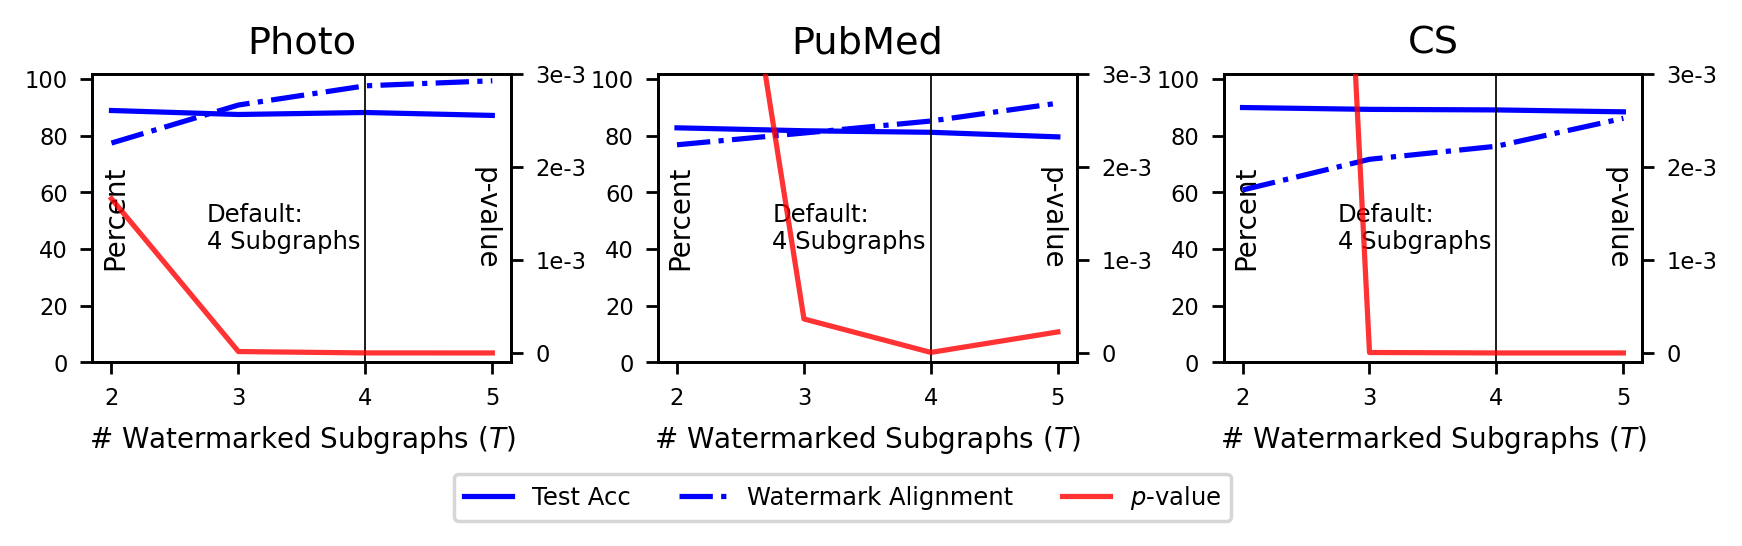

4 SUBGRAPHS, SIZE 0.001:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   97.6/91.4            48.8          0.588

for latex table:
97.6/91.4 & 48.8 & 0.588
4 SUBGRAPHS, SIZE 0.002:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   96.5/90.1            68.0          0.384

for latex table:
96.5/90.1 & 68.0 & 0.384
4 SUBGRAPHS, SIZE 0.003:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   95.5/89.8            74.3          0.194

for latex table:
95.5/89.8 & 74.3 & 0.194
4 SUBGRAPHS, SIZE 0.004:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   94.8/88.2            82.5          0.002

for latex table:
94.8/88.2 & 82.5 & 0.002
4 SUBGRAPHS, SIZE 0.005:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   94.1/88.2            97.7          <0.001

for latex table:
94.1/88.2 & 97.7 & <0.001
4 SUBGRAPHS, SIZE 0.006:
   ACC_TRN/ACC_VAL      MATCH_RATE    P-VAL
   93.9/87.5            99.3          <0.001

for latex table:
93.9/87.5 & 99.3 & <0.001
4 SUBGRAPHS, SIZE 0.007:
   ACC_TRN/ACC_VAL      MATCH_RATE 

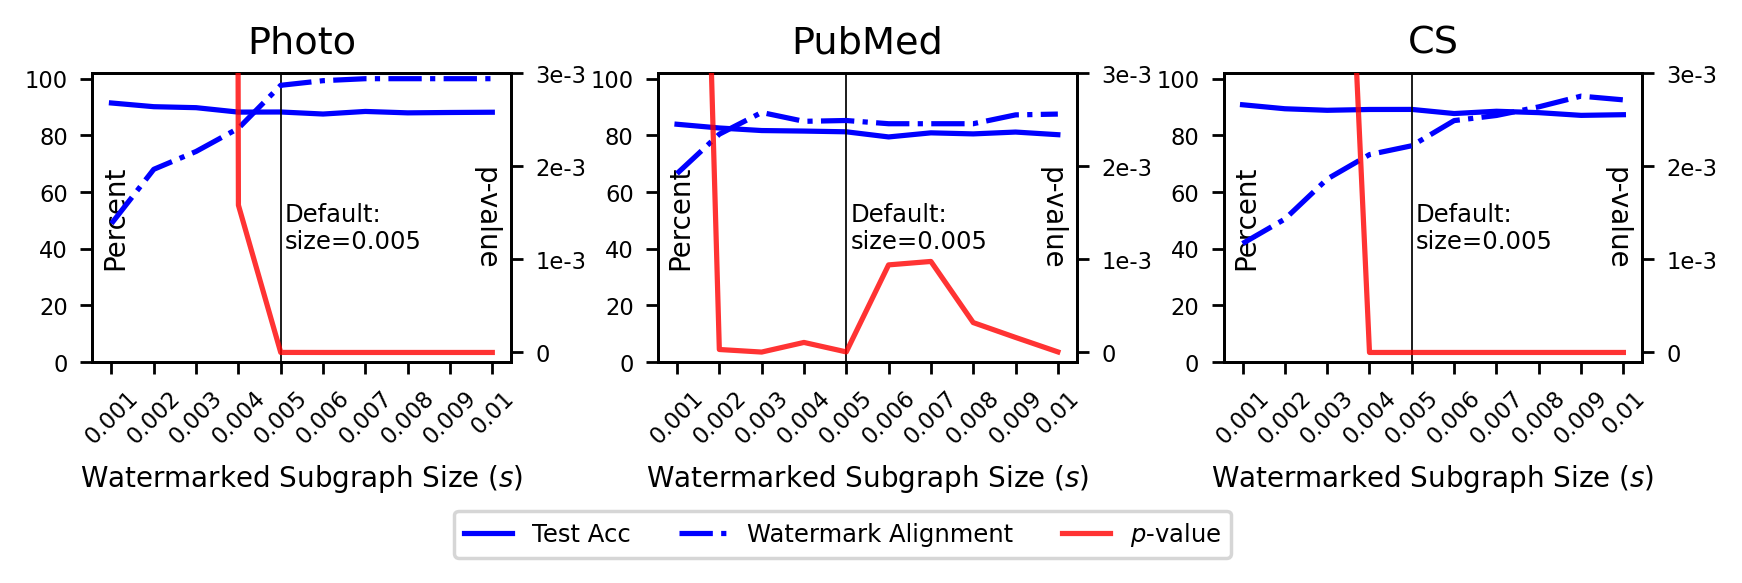

In [6]:
import os


def go(dataset_name, seed, architecture_folder, num_subgraphs, subgraph_size, verification_confidence, continuation=False, starting_epoch=0):
    try:
        current_dir = os.path.dirname(os.path.abspath(__file__))
    except:
        current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)    

    data_training_path = f'{parent_dir}/training_results/{dataset_name}/'
    if len(architecture_folder.split('/'))<3:
        architecture_folder = os.path.join(data_training_path, architecture_folder)

    train_val_test_split = [0.6,0.2,0.2]
    dataset = prep_data(dataset_name=dataset_name, location='default', batch_size='default', transform_list='default',  train_val_test_split=train_val_test_split, verbose=False)
    data = dataset[0]
    get_presets(dataset,dataset_name)
    config.subgraph_kwargs['numSubgraphs']=num_subgraphs
    
    def obtain_final_significance_against_empirical(Trainer_object, data, subgraph_dict_not_watermarked, mu_natural_empirical, sigma_natural_empirical):
        watermark_loss_kwargs = config_dict['watermark_loss_kwargs']
        optimization_kwargs = config_dict['optimization_kwargs']
        regression_kwargs = config_dict['regression_kwargs']
        node_classifier = Trainer_object.node_classifier
        watermark_match_rates, acc_trn, _, acc_val, target_matches, [_, match_count_wmk_without_zeros, _, confidence_wmk_without_zeros], \
            [_, _, _, _] = easy_run_node_classifier(Trainer_object, node_classifier, data, mu_natural_empirical, sigma_natural_empirical, subgraph_dict, subgraph_dict_not_watermarked, watermark_loss_kwargs, optimization_kwargs, regression_kwargs, target_confidence=verification_confidence,also_show_un_watermarked_counts=False)
        return acc_trn, acc_val, target_matches, match_count_wmk_without_zeros, confidence_wmk_without_zeros, watermark_match_rates
    
    model_paths = [os.path.join(architecture_folder, folder) for folder in os.listdir(architecture_folder) if folder[0]!='.' and 'ignore' not in folder]
    model_path = [p for p in model_paths if int(p.split('numSubgraphs')[1].split('_')[0])==num_subgraphs and float(p.split('fraction')[1].split('_')[0])==subgraph_size][0]
    assert os.path.exists(model_path)
    seeds = [seed_name for seed_name in os.listdir(model_path) if seed_name[0]!='.' and '.png' not in seed_name and 'ignore' not in seed_name]
    avg_acc_trn, avg_acc_val, avg_match_count_wmk_without_zeros, avg_confidence_wmk_without_zeros, avg_wmk_match_rates = [],[],[],[],[]
    avg_p_vals = []
    for seed in seeds:
        full_model_path = os.path.join(model_path,seed)
        assert os.path.exists(os.path.join(full_model_path,'config_dict'))
        config_dict = pickle.load(open(os.path.join(full_model_path,'config_dict'),'rb'))
        subgraph_dict_filename = 'subgraph_dict' if continuation==False else f'subgraph_dict_continuation_from_{starting_epoch}'
        subgraph_dict = pickle.load(open(os.path.join(full_model_path,subgraph_dict_filename),'rb'))
        Trainer_object_filename = 'Trainer' if continuation==False else f'Trainer_continuation_from_{starting_epoch}'
        Trainer_object = pickle.load(open(os.path.join(full_model_path,Trainer_object_filename),'rb'))
        distribution_records_filename = 'distribution.txt' if continuation==False else f'distribution_continuation_from_{starting_epoch}.txt'
        distribution_records_file = os.path.join(full_model_path,distribution_records_filename)
        with open(distribution_records_file,'r') as f:
            lines = f.readlines()
        f.close()
        mu_natural_empirical = float(lines[1].split('mu_natural=')[1].split(',')[0])
        sigma_natural_empirical = float(lines[1].split('sigma_natural=')[1])
        acc_trn, acc_val, _, match_count_wmk_without_zeros, confidence_wmk_without_zeros, watermark_match_rates = obtain_final_significance_against_empirical(Trainer_object, data, None, mu_natural_empirical, sigma_natural_empirical)
        avg_acc_trn.append(acc_trn.item())
        avg_acc_val.append(acc_val.item())
        avg_match_count_wmk_without_zeros.append(match_count_wmk_without_zeros)
        avg_confidence_wmk_without_zeros.append(confidence_wmk_without_zeros)
        avg_wmk_match_rates.append(watermark_match_rates)
        conf = np.mean(avg_confidence_wmk_without_zeros)
        avg_p_vals.append(1-conf)
    
    avg_trn_acc = np.mean(avg_acc_trn)
    avg_val_acc = np.mean(avg_acc_val)
    avg_match_rate = np.mean(watermark_match_rates)
    avg_p_val = np.mean(avg_p_vals)
    return avg_trn_acc, avg_val_acc,avg_match_rate, avg_p_val
    # avg_p_val_str = '<0.001' if avg_p_val<0.001 else f'{avg_p_val:.3f}'
    # print(f'{num_subgraphs} SUBGRAPHS, SIZE {subgraph_size}:')
    # print('ACC_TRN/ACC_VAL'.ljust(16) + 'MATCH_RATE'.ljust(14) + 'P-VAL')
    # print(f'{100*avg_trn_acc:.1f}/{100*avg_trn_val:.1f}'.ljust(16) + f'{avg_match_rate:.1f}'.ljust(14) + avg_p_val_str)
    # ret_str = f'{100*avg_trn_acc:.1f}/{100*avg_val_acc:.1f} & {avg_match_rate:.1f} & {avg_p_val_str}'
    # return ret_str

seed=0






def ablation_plot(recollect=False, arch='SAGE', num_subgraph=4,exclude_title=False, variable='subgraph_size',
                                  xticksize=7,yticksize=7,xlabelsize=9,ylabelsize=9,smalltitlesize=11,bigtitlesize=13,legendtitlesize=7,annotatesize=7,xrotation=45):
    starting_epoch=0
    subgraph_sizes = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
    num_subgraphs  = [2,3,4,5]
    num_subgraph=4
    subgraph_size=0.005
    fig = plt.figure(figsize=(8,1.5))
    gs = gridspec.GridSpec(1, 3, figure=fig)
    for i, dataset_name in enumerate(['photo','PubMed','CS']):
        current_dir = os.getcwd()
        parent_dir = os.path.dirname(current_dir)
        train_results_dir = os.path.join(parent_dir,'training_results',dataset_name)
        ax = fig.add_subplot(gs[0,i])
        root = '/Users/janedowner/Desktop/Desktop/IDEAL/'
        if dataset_name=='PubMed':
            if arch=='GCN':
                architecture_folder = root+'Project_2/training_results/PubMed/archGCN_elu_nLayers3_hDim512_drop0.8_skipTrue'
            elif arch=='SGC':
                architecture_folder = root+'Project_2/training_results/PubMed/archSGC_elu_nLayers3_hDim512_drop0.8_skipTrue'
            elif arch=='SAGE':
                print('here')
                architecture_folder = root+'Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim512_drop0.95_skipTrue'
        else:
            architecture_folder = root+f'Project_2/training_results/{dataset_name}/arch{arch}_elu_nLayers3_hDim256_drop0.1_skipTrue'

        verification_confidence=0.99

        if recollect==True:
            train_accs = []
            val_accs = []
            match_rates = []
            p_vals = []
            if variable=='subgraph_size':
                for subgraph_size in subgraph_sizes:
                    avg_trn_acc, avg_val_acc,avg_match_rate, avg_p_val = go(dataset_name, seed, architecture_folder,num_subgraphs=num_subgraph,subgraph_size=subgraph_size,verification_confidence=verification_confidence, continuation=False,starting_epoch=starting_epoch)
                    train_accs.append(avg_trn_acc)
                    val_accs.append(avg_val_acc)
                    match_rates.append(avg_match_rate)
                    p_vals.append(avg_p_val)  
                    get_performance_printout_for_subgraph_size(num_subgraph, subgraph_size, avg_trn_acc, avg_val_acc, avg_match_rate, avg_p_val)         
                    latex_str = get_latex_str_for_subgraph_size(avg_trn_acc, avg_val_acc, avg_match_rate, avg_p_val)
                    print('\nfor latex table:')
                    print(latex_str)
                with open(os.path.join(train_results_dir,'subgraph_size_comparison.txt'),'w') as f:
                    f.write(f'subgraph_sizes: {subgraph_sizes}')
                    f.write(f'\ntrain_accs: {train_accs}')
                    f.write(f'\nval_accs: {val_accs}')
                    f.write(f'\nmatch_rates: {match_rates}')
                    f.write(f'\np_values: {p_vals}')
                f.close()
            elif variable=='num_subgraph':
                for num_subgraph in num_subgraphs:
                    avg_trn_acc, avg_val_acc,avg_match_rate, avg_p_val = go(dataset_name, seed, architecture_folder,num_subgraphs=num_subgraph,subgraph_size=subgraph_size,verification_confidence=verification_confidence, continuation=False,starting_epoch=starting_epoch)
                    train_accs.append(avg_trn_acc)
                    val_accs.append(avg_val_acc)
                    match_rates.append(avg_match_rate)
                    p_vals.append(avg_p_val)  
                    get_performance_printout_for_subgraph_size(num_subgraph, subgraph_size, avg_trn_acc, avg_val_acc, avg_match_rate, avg_p_val)         
                    latex_str = get_latex_str_for_subgraph_size(avg_trn_acc, avg_val_acc, avg_match_rate, avg_p_val)
                    print('\nfor latex table:')
                    print(latex_str)
                with open(os.path.join(train_results_dir,'num_subgraph_comparison.txt'),'w') as f:
                    f.write(f'num_subgraphs: {num_subgraphs}')
                    f.write(f'\ntrain_accs: {train_accs}')
                    f.write(f'\nval_accs: {val_accs}')
                    f.write(f'\nmatch_rates: {match_rates}')
                    f.write(f'\np_values: {p_vals}')
                f.close()
        else:
            if variable=='subgraph_size':
                with open(os.path.join(train_results_dir,'subgraph_size_comparison.txt'),'r') as f:
                    subgraph_sizes = ast.literal_eval(f.readline().split('subgraph_sizes: ')[1].split('\n')[0])
                    train_accs = ast.literal_eval(f.readline().split('train_accs: ')[1].split('\n')[0])
                    val_accs = ast.literal_eval(f.readline().split('val_accs: ')[1].split('\n')[0])
                    match_rates = ast.literal_eval(f.readline().split('match_rates: ')[1].split('\n')[0])
                    p_vals = ast.literal_eval(f.readline().split('p_values: ')[1])
                f.close()
                for s,t,v,m,p in zip(subgraph_sizes,train_accs,val_accs,match_rates, p_vals):
                    get_performance_printout_for_subgraph_size(num_subgraph, s, t, v, m, p)         
                    latex_str = get_latex_str_for_subgraph_size(t, v, m, p)
                    print('\nfor latex table:')
                    print(latex_str)
            elif variable=='num_subgraph':
                with open(os.path.join(train_results_dir,'num_subgraph_comparison.txt'),'r') as f:
                    num_subgraphs = ast.literal_eval(f.readline().split('num_subgraphs: ')[1].split('\n')[0])
                    train_accs = ast.literal_eval(f.readline().split('train_accs: ')[1].split('\n')[0])
                    val_accs = ast.literal_eval(f.readline().split('val_accs: ')[1].split('\n')[0])
                    match_rates = ast.literal_eval(f.readline().split('match_rates: ')[1].split('\n')[0])
                    p_vals = ast.literal_eval(f.readline().split('p_values: ')[1])
                f.close()
                for n,t,v,m,p in zip(num_subgraphs,train_accs,val_accs,match_rates, p_vals):
                    get_performance_printout_for_subgraph_size(n, subgraph_size, t, v, m, p)         
                    latex_str = get_latex_str_for_subgraph_size(t, v, m, p)
                    print('\nfor latex table:')
                    print(latex_str)

        if variable=='num_subgraph':
            xvals=num_subgraphs
            default_str='Default:\n4 Subgraphs'
            xlabel='# Watermarked Subgraphs ($T$)'
            default_value=4
        elif variable=='subgraph_size':
            xvals=subgraph_sizes
            default_str='Default:\nsize=0.005'
            xlabel=f'Watermarked Subgraph Size ($s$)'
            default_value=0.005

        ax2 = ax.twinx()
        ax.axvline(default_value,color='black',lw=0.5)
        ax.plot(xvals,[100*a for a in val_accs],color='blue',label='Test Acc',zorder=1) ## we switch the names of "test" and "validation" in the paper results
        ax.plot(xvals,match_rates,color='blue',linestyle='dashdot',label='Watermark Alignment',zorder=2)
        ax2.plot(xvals,p_vals,color='red',label='$p$-value',zorder=3,alpha=0.8)
        text_x = 0.0051 if variable=='subgraph_size' else 2.75
        ax.text(text_x,40,default_str,color='black',fontsize=annotatesize,zorder=10,clip_on=False)
        ax.set_xticks(xvals)
        ax.set_xticklabels(xvals,fontsize=xticksize,rotation=xrotation)
        acc_ticks = [0,20,40,60,80,100]
        ax.set_yticks(acc_ticks)
        ax.set_yticklabels(acc_ticks,fontsize=yticksize)
        ax2_yticks = [0, 1e-3, 2e-3, 3e-3]
        ax2_ytick_labels = ['0', '1e-3', '2e-3', '3e-3']
        ax2.set_yticks(ax2_yticks)
        ax2.set_yticklabels(ax2_ytick_labels,fontsize=yticksize)
        ax.set_ylim(0,102)
        ax2.set_ylim(-0.0001,0.003)
        ax.set_ylabel('Percent',fontsize=ylabelsize,labelpad=-30)
        # ax.yaxis.set_label_coords(-0,1.03)  # Adjust x and y coordinates for position
        ax.set_xlabel(xlabel,fontsize=xlabelsize)
        ax2.set_ylabel('p-value',fontsize=ylabelsize,labelpad=-25,rotation=270)
        # ax2.yaxis.set_label_coords(1,1.13)  # Adjust x and y coordinates for position
        ax.set_title(dataset_name.capitalize() if dataset_name=='photo' else dataset_name,fontsize=smalltitlesize)



    ax_handles, ax_labels = ax.get_legend_handles_labels()
    ax2_handles, ax2_labels = ax2.get_legend_handles_labels()
    handles = ax_handles + ax2_handles
    labels = ax_labels + ax2_labels
    legend_y=-0.35 if variable=='subgraph_size' else -0.25
    fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, legend_y), ncol=3,fontsize=legendtitlesize)
    if exclude_title==False:
        fig.suptitle('Performance Metrics vs. Target Subgraph Size',y=1.1,fontsize=bigtitlesize)
    fig.subplots_adjust(wspace=0.35)



    plt.savefig(f'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/ICLR_photos/performance_vs_{variable}.png',bbox_inches='tight',dpi=300)
    plt.show()



num_subgraph=4
arch='SAGE'
xticksize=6.5
yticksize=6.5
xlabelsize=8
ylabelsize=8
smalltitlesize=11
bigtitlesize=13
legendtitlesize=7
annotatesize=7
exclude_title=True
variable='num_subgraph'
xrotation=45 if variable=='subgraph_size' else 0
recollect=False
ablation_plot(recollect=recollect, arch=arch, num_subgraph=num_subgraph,exclude_title=exclude_title, variable=variable,
                            xticksize=xticksize,yticksize=yticksize,xlabelsize=xlabelsize,ylabelsize=ylabelsize,
                            smalltitlesize=smalltitlesize,bigtitlesize=bigtitlesize,legendtitlesize=legendtitlesize,annotatesize=annotatesize,xrotation=xrotation)
variable='subgraph_size'
xrotation=45 if variable=='subgraph_size' else 0
recollect=False
ablation_plot(recollect=recollect, arch=arch, num_subgraph=num_subgraph,exclude_title=exclude_title, variable=variable,
                            xticksize=xticksize,yticksize=yticksize,xlabelsize=xlabelsize,ylabelsize=ylabelsize,
                            smalltitlesize=smalltitlesize,bigtitlesize=bigtitlesize,legendtitlesize=legendtitlesize,annotatesize=annotatesize,xrotation=xrotation)



In [11]:
import math
def binom(n, k):
    if k > n:
        return 0
    return math.comb(n, k)

num_graphs = binom(4590, 23)
num_groups = binom(num_graphs,4)


/Users/janedowner/miniforge3/envs/proj_2_env/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

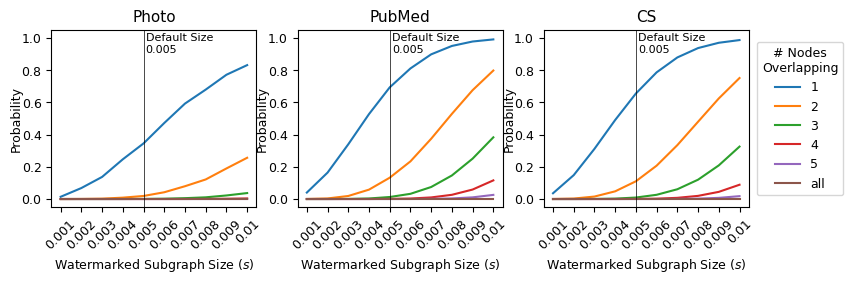

In [12]:
import math



def binom(n, k):
    if k > n:
        return 0
    return math.comb(n, k)

# Function to compute the probability
def probability_at_least_j_same_group(N, k, c, n_sub, j):
    # Each group size
    group_size = k // c
    # Total ways to choose n_sub from the whole population
    total_ways = binom(N, n_sub)
    # Probability of selecting fewer than j from a single group
    def prob_less_than_j_from_group():
        sum_prob = 0
        for m in range(j):
            # Select m from the group and (n_sub - m) from non-group
            sum_prob += binom(group_size, m) * binom(N - group_size, n_sub - m)
        return sum_prob / total_ways
    # Probability of no group having j or more from the same group
    prob_no_group_j_or_more = prob_less_than_j_from_group() ** c
    # Final probability (at least j from the same group)
    return 1 - prob_no_group_j_or_more


def plot_overlap_probability(num_subgraph, xrotation=45,xticksize=7,yticksize=7,xlabelsize=8,ylabelsize=8,annotationsize=7,legendsize=8,legendtitlesize=8,bigtitlesize=13,smalltitlesize=11):
    subgraph_sizes = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
    fig,axs=plt.subplots(1,3,figsize=(9,2.3))
    for i, dataset_name in enumerate(['photo','PubMed','CS']):
        ax=axs[i]
        dataset = prep_data(dataset_name=dataset_name, location='default', batch_size='default', transform_list='default',  train_val_test_split=[0.6,0.2,0.2], verbose=False)
        data = dataset[0]
        len_train = len_train=sum(data.train_mask).item()

        # fig,ax = plt.subplots(1,1,figsize=(4,2))
        subgraph_size_overlap_dicts={j:[] for j in [1,2,3,4,5,'n_sub']}
        for subgraph_size in subgraph_sizes:
            n_sub = int(subgraph_size*len_train)
            num_target_entries=  n_sub*4
            for j in [1,2,3,4,5,'n_sub']:
                j_ = n_sub if j=='n_sub' else j
                p_j_overlap = probability_at_least_j_same_group(len_train, num_target_entries, num_subgraph, n_sub, j_)
                subgraph_size_overlap_dicts[j].append(p_j_overlap)
        for j in [1,2,3,4,5,'n_sub']:
            j_key = j if j!='n_sub' else 'all'
            ax.plot(subgraph_sizes,subgraph_size_overlap_dicts[j],label=j_key)

        p_intervals=[0.0,0.2,0.4,0.6,0.8,1.0]
        ax.set_yticks(p_intervals)
        ax.set_yticklabels(p_intervals,fontsize=yticksize)
        ax.set_xticks(subgraph_sizes)
        ax.set_xticklabels(subgraph_sizes,fontsize=xticksize,rotation=xrotation)
        ax.text(0.0051,0.91,'Default Size\n0.005',color='black',fontsize=annotationsize)
        ax.set_ylabel(f'Probability',fontsize=ylabelsize,labelpad=-1)
        ax.set_xlabel(f'Watermarked Subgraph Size ($s$)',fontsize=xlabelsize)
        ax.axvline(0.005,color='black',lw=0.5)
        ax.set_ylim(-0.05,1.05)
        ax.set_title('Photo' if dataset_name=='photo' else dataset_name,fontsize=smalltitlesize)
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(1.25, 0.5), ncol=1,fontsize=legendsize, title='# Nodes\nOverlapping',title_fontsize=legendtitlesize)
    legend.get_title().set_ha('center')
    # fig.suptitle('Probability of Attacker-Chosen Subgraph Overlapping with a Watermarked Subgraph',fontsize=bigtitlesize,y=1.04)
    fig.subplots_adjust(wspace=0.2)
    plt.savefig('/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/ICLR_photos/probability_of_overlap.png',bbox_inches='tight',dpi=300)
    plt.show()


plot_overlap_probability(4, xrotation=45,xticksize=9,yticksize=9,xlabelsize=9,ylabelsize=9,annotationsize=8,legendsize=9,legendtitlesize=9,bigtitlesize=13,smalltitlesize=11)

In [13]:
def P(k,s):
    print(f's^2: {s**2}, k: {k}, (s+1)^2: {(s+1)**2}')
    if s**2 <=k and k <= (s+1)**2:
        return True
    else:
        print(f'False for (s={s},k={k})')
        return False
    

k=5
for s in range(-5,0):
    P(k,s)

s^2: 25, k: 5, (s+1)^2: 16
False for (s=-5,k=5)
s^2: 16, k: 5, (s+1)^2: 9
False for (s=-4,k=5)
s^2: 9, k: 5, (s+1)^2: 4
False for (s=-3,k=5)
s^2: 4, k: 5, (s+1)^2: 1
False for (s=-2,k=5)
s^2: 1, k: 5, (s+1)^2: 0
False for (s=-1,k=5)


In [71]:
def gather_prune_stats(model_path, confidence, pruning_type='structured',ignore_zeros=True):
    assert pruning_type in ['structured','unstructured']
    #if continuation==False:
    file = f'results_prune_{pruning_type}.txt'
    #lse:
       # file = [f for f in os.listdir(model_path) if 'continuation' in f and 'results_prune' in f][0]
      #  print('file:',file)
    dataset_name = model_path.split('training_results')[1].split('/')[1].split('/')[0]
    all_train_accs = []
    all_val_accs = []
    all_wmk_matches = []
    all_target_matches_empirical = []
    all_mu_natural_empirical = []
    all_sigma_natural_empirical = []

    seeds = [path.split('seed')[1] for path in os.listdir(model_path) if path[0]!='.' and 'png' not in path]
    for seed in seeds:
        full_path = os.path.join(model_path,f'seed{seed}',file)
        with open(full_path,'r') as f:
            lines = f.readlines()
        f.close()
        prune_rates = [float(l_.split()[0]) for l_ in [l for l in ''.join(lines).split('Prune rate: ') if len(l)>0]]
        all_train_accs.append([float(l.split('Trn acc: ')[1].split()[0]) for l in lines[1:]])#[1::2]])
        all_val_accs.append([float(l.split('Val acc: ')[1].split()[0]) for l in lines[1:]])#[1::2]])
        if ignore_zeros==True:
            all_wmk_matches.append([int(l.split('# Matches Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[1]) for l in [line for line in lines if "# Matches" in line]])
            #all_un_wmk_matches.append([int(l.split('# Matches Not Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[1]) for l in [line for line in lines[0::2] if "# Matches" in line]])
        elif ignore_zeros==False:
            all_wmk_matches.append([int(l.split('# Matches Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[0]) for l in [line for line in lines if "# Matches" in line]])
            #all_un_wmk_matches.append([int(l.split('# Matches Not Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[0]) for l in [line for line in lines[0::2] if "# Matches" in line]])
        
        mu_natural_empirical = float(''.join(open(os.path.join(model_path,f'seed{seed}','distribution.txt')).readlines()).split('mu_natural=')[1].split(',')[0])
        sigma_natural_empirical = float(''.join(open(os.path.join(model_path,f'seed{seed}','distribution.txt')).readlines()).split('sigma_natural=')[1].split(',')[0])
        z_t = norm.ppf(confidence)
        all_mu_natural_empirical.append(mu_natural_empirical)
        all_sigma_natural_empirical.append(sigma_natural_empirical)       
        target_matches_empirical = np.ceil(min(mu_natural_empirical +z_t*sigma_natural_empirical,config.dataset_attributes[dataset_name]['num_features']))
        all_target_matches_empirical.append(target_matches_empirical) 

    train_accs = torch.mean(torch.vstack([torch.tensor(l) for l in all_train_accs]),dim=0)
    val_accs = torch.mean(torch.vstack([torch.tensor(l) for l in all_val_accs]),dim=0)
    wmk_matches = torch.mean(torch.vstack([torch.tensor(l) for l in all_wmk_matches]),dtype=float,dim=0)
    # un_wmk_matches =torch.mean(torch.vstack([torch.tensor(l) for l in all_un_wmk_matches]),dtype=float,dim=0)
    mu_natural_empirical = int(np.round(np.mean(all_mu_natural_empirical)))
    sigma_natural_empirical = int(np.round(np.mean(all_sigma_natural_empirical)))
    target_matches_empirical = int(np.round(np.mean(all_target_matches_empirical)))

    return prune_rates, train_accs, val_accs, wmk_matches, target_matches_empirical, mu_natural_empirical, sigma_natural_empirical

def gather_fine_tune_stats(model_path, confidence, ignore_zeros=True, lr=None, lr_scale=None, seeds=[1,2,3,4]):#, continuation=False, starting_epoch=0):
    print("lr_scale:",lr_scale)
    if lr is not None:
        assert lr_scale is None
        file = f'results_fine_tune_lr={float(lr)}.txt' if lr is not None else 'results_fine_tune.txt' # if continuation==False else f'results_fine_tune_continuation_from_{starting_epoch}.txt'
    elif lr_scale is not None:
        assert lr is None
        file = f'results_fine_tune_lr_scale={float(lr_scale)}.txt' if lr_scale is not None else 'results_fine_tune.txt' # if continuation==False else f'results_fine_tune_continuation_from_{starting_epoch}.txt'
    else:
        file = 'results_fine_tune.txt'

    dataset_name = model_path.split('training_results')[1].split('/')[1].split('/')[0]
    all_wmk_matches = []
    # all_un_wmk_matches = []
    seeds_ = [path.split('seed')[1] for path in os.listdir(model_path) if path[0]!='.' and 'png' not in path]# and int(path.split('seed')[1]) in seeds]
    if seeds is not None:
        seeds_ = [s for s in seeds_ if int(s) in seeds]
    print('seeds_:',seeds_)

    all_target_matches_empirical = []
    all_mu_natural_empirical = []
    all_sigma_natural_empirical = []
    og_trn_accs = []
    new_trn_accs = []
    val_accs = []


    for seed in seeds_:
        full_path = os.path.join(model_path,f'seed{seed}',file)
        print('full_path:',full_path)
        with open(full_path,'r') as f:
            lines = f.readlines()
        f.close()

        epochs = [int(l.split('Epoch:')[1].split(',')[0].split()[0]) for l in lines]
        if ignore_zeros==True:
            l1 = [int(l.split('#_match_wmk w/wout 0s =')[1].split(', confidence')[0].split()[0][1:-1].split(',')[1]) for l in lines]
            all_wmk_matches.append(l1)
        elif ignore_zeros==False:
            l1=[int(l.split('#_match_wmk w/wout 0s =')[1].split(', confidence')[0].split()[0][1:-1].split(',')[0]) for l in lines]
            all_wmk_matches.append(l1)

        og_trn_accs.append([float(l.split('train (og) acc = ')[1].split(',')[0]) for l in lines])
        # new_trn_accs.append([float(l.split('train (test) acc = ')[1].split(',')[0]) for l in lines])
        new_trn_accs.append([float(l.split('train (fine-tune) acc = ')[1].split(',')[0]) for l in lines])
        val_accs.append([float(l.split('val acc = ')[1].split(',')[0]) for l in lines])


        mu_natural_empirical = float(''.join(open(os.path.join(model_path,f'seed{seed}','distribution.txt')).readlines()).split('mu_natural=')[1].split(',')[0])
        sigma_natural_empirical = float(''.join(open(os.path.join(model_path,f'seed{seed}','distribution.txt')).readlines()).split('sigma_natural=')[1].split(',')[0])
        z_t = norm.ppf(confidence)
        all_mu_natural_empirical.append(mu_natural_empirical)
        all_sigma_natural_empirical.append(sigma_natural_empirical)       
        target_matches_empirical = np.ceil(min(mu_natural_empirical +z_t*sigma_natural_empirical,config.dataset_attributes[dataset_name]['num_features']))
        all_target_matches_empirical.append(target_matches_empirical) 

    wmk_matches = torch.mean(torch.vstack([torch.tensor(l) for l in all_wmk_matches]),dtype=float,dim=0)
    mu_natural_empirical = int(np.round(np.mean(all_mu_natural_empirical)))
    sigma_natural_empirical = int(np.round(np.mean(all_sigma_natural_empirical)))
    target_matches_empirical = int(np.round(np.mean(all_target_matches_empirical)))
    og_trn_accs = torch.mean(torch.vstack([torch.tensor(l) for l in og_trn_accs]),dtype=float,dim=0)
    new_trn_accs = torch.mean(torch.vstack([torch.tensor(l) for l in new_trn_accs]),dtype=float,dim=0)
    val_accs = torch.mean(torch.vstack([torch.tensor(l) for l in val_accs]),dtype=float,dim=0)

    return epochs, wmk_matches, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, og_trn_accs, new_trn_accs, val_accs


from scipy.stats import norm
from matplotlib import patches, transforms

def arrow(ax, target_matches):
    x_start = 0.05
    trans = transforms.blended_transform_factory(ax.transAxes,ax.transAxes)
    if target_matches > ax.get_ylim()[1]:
        y_start  = 0.85#y_ub-0.1
        dy = 0.05
    elif target_matches < ax.get_ylim()[0]: 
        y_start = 0.15#y_lb+0.1
        dy = -0.05
    arrow = patches.FancyArrow(x_start, y_start, 0, dy, transform=trans,  color='r', width=0.02,  head_width=0.05, head_length=0.06)
    ax.add_patch(arrow)



def arrow_off_plot(ax, curve):
    x_start = 0.05
    trans = transforms.blended_transform_factory(ax.transAxes,ax.transAxes)
    if sum([c > ax.get_ylim()[1] for c in curve])==len(curve):
    # if target_matches > ax.get_ylim()[1]:
        y_start  = 0.85#y_ub-0.1
        dy = 0.05
        arrow = patches.FancyArrow(x_start, y_start, 0, dy, transform=trans,  color='r', width=0.02,  head_width=0.05, head_length=0.06)
        ax.add_patch(arrow)
        return True
    return False

def prune_plot(prune_rates, train_accs, val_accs, wmk_matches, c, mu_natural, sigma_natural, target_matches, axs=None,
               xlabelsize=8, xticksize=8,yticksize=8,ylabelsize=8,bigtitlesize=13,smalltitlesize=11, ablation=False, ablation_value=None, ablation_color='blue'):
    
    exclude_accuracies = True if len(axs)==1 else False
    if ablation==True:
        assert ablation_value is not None

    def scale_y1_to_pvalue(y1_value, mu_natural, sigma_natural):
        z_score = (y1_value - mu_natural)/sigma_natural
        p_value = 1-stats.norm.cdf(z_score)
        return p_value


    if exclude_accuracies==True:
        if axs is None:
            fig, ax = plt.subplots(1, 1, figsize=(3, 4))
            pval_ax = ax
        else:
            fig = None
            pval_ax = axs[0]

    elif exclude_accuracies==False:
        if axs is None:
            fig, axs = plt.subplots(2, 1, figsize=(3, 4))
            acc_ax = axs[0]
            pval_ax = axs[1]
        else:
            fig = None
            acc_ax, pval_ax = axs[0], axs[1]
    target_matches=0.95
    wmk_matches = torch.tensor([scale_y1_to_pvalue(num_matches, mu_natural, sigma_natural) for num_matches in wmk_matches])

    if exclude_accuracies==False:
        if ablation==True:
            acc_ax.plot(prune_rates, val_accs, label='Test Acc',color=ablation_color,linestyle='solid') # switch names of "test" and "validation" for paper results
        else:
            acc_ax.plot(prune_rates, train_accs, label='Train Acc',color='blue',linestyle='solid')
            acc_ax.plot(prune_rates, val_accs, label='Test Acc',color='blue',linestyle='dotted') # switch names of "test" and "validation" for paper results

    label=ablation_value if ablation==True else 'MI $p$-value'
    pval_curve_color = 'green' if ablation==False else ablation_color
    pval_ax.plot(prune_rates, wmk_matches, label=label,color=pval_curve_color)
    x_lb = -0.05
    x_ub = max(prune_rates)#0.95


    y_min = int(np.floor(torch.min(wmk_matches).item()))
    y_max = int(np.ceil(torch.max(wmk_matches).item()))
    if target_matches >= y_min and target_matches <= y_max:
        pval_ax.axhline(target_matches, color='red',linestyle=':',linewidth=1)
        pval_ax.axhline(0,linewidth=0.3,color='gray')
        pval_ax.axhline(0.01,linewidth=0.3,color='gray')
        pval_ax.axhline(0.05,linewidth=0.3,color='gray')
        pval_ax.axhline(0.1,linewidth=0.3,color='gray')
        pval_ax.axhline(0.2,linewidth=0.3,color='gray')
    else:
        arrow(pval_ax, target_matches)
        y_text_pos = y_min+0.9*(y_max-y_min) if target_matches>y_min else y_min+0.1*(y_max-y_min)
        x_text_pos = x_lb+0.1*(x_ub-x_lb)
        pval_ax.text(x_text_pos,y_text_pos, f'Target # Matches = {int(target_matches)}')


    if fig:    
        fig.suptitle('Effect of Model Pruning on Performance',y=1.01, fontsize=bigtitlesize)
        fig.text(0.5, 0.9, f'("{dataset_name.capitalize()}", {c} Subgraphs)', ha='center', fontsize=smalltitlesize)
    if len(prune_rates)>20:
        prune_rate_xticks = prune_rates[:-1][::10]
    else:
        prune_rate_xticks = prune_rates[:-1]

    if exclude_accuracies==False:
        accuracy_yticks = [0,0.2,0.4,0.6,0.7,0.8,1]
        acc_ax.set_ylim(0,1.01)
        y_lb = acc_ax.get_ylim()[0]
        y_lb_index = accuracy_yticks.index(y_lb)
        accuracy_yticks = accuracy_yticks[y_lb_index+1:]
        acc_ax.set_yticks(accuracy_yticks)
        acc_ax.set_xlabel('Prune Rate',fontsize=xlabelsize)
        acc_y_label='Accuracy' if ablation==False else 'Test Acc' # switch names of "test" and "validation" for paper results
        acc_ax.set_ylabel(acc_y_label,fontsize=ylabelsize)
        acc_ax.set_xlim(-0.05,x_ub)
        acc_ax.set_xticks(prune_rate_xticks)
        acc_ax.set_xticklabels(prune_rate_xticks,fontsize=xticksize)
        acc_ax.set_yticks(accuracy_yticks)
        acc_ax.set_yticklabels(accuracy_yticks,fontsize=yticksize)

    p_val_yticks = [0.01,0.05,0.1,0.2]
    pval_ax.set_xlabel('Prune Rate',fontsize=xlabelsize)
    pval_ax.set_ylabel('$p$-value',fontsize=ylabelsize)
    pval_ax.set_xlim(x_lb, x_ub)
    pval_ax.set_ylim(-0.01,0.21)
    pval_ax.set_xticks(prune_rate_xticks)
    pval_ax.set_xticklabels(prune_rate_xticks,fontsize=xticksize)
    pval_ax.set_yticks(p_val_yticks)
    pval_ax.set_yticklabels(p_val_yticks,fontsize=yticksize)
    val_off_plot = arrow_off_plot(pval_ax, wmk_matches)
    return val_off_plot

def fine_tune_plot(dataset_name, epochs, wmk_matches, c, mu_natural, sigma_natural, target_matches, og_trn_accs, new_trn_accs, val_accs, model_path, axs=None,
                   xlabelsize=8, xticksize=8,yticksize=8,ylabelsize=8,bigtitlesize=13,smalltitlesize=11, ablation=False, ablation_value=None, ablation_color='blue'):
    
    print('mu_natural, sig_natural:',mu_natural, sigma_natural)
    def scale_y1_to_pvalue(y1_value, mu_natural, sigma_natural):
        z_score = (y1_value - mu_natural)/sigma_natural
        p_value = 1-stats.norm.cdf(z_score)
        return p_value
    # def inverse_convert(p_value):
    #     z_score = stats.norm.ppf(p_value)
    #     y1_value = z_score * sigma_natural + mu_natural
    #     return y1_value

    exclude_accuracies=True if len(axs)==1 else False
    target_matches=0.95
    print('num_matches:',wmk_matches)
    wmk_matches = torch.tensor([scale_y1_to_pvalue(num_matches, mu_natural, sigma_natural) for num_matches in wmk_matches])

    if ablation==True:
        assert ablation_value is not None
        label=ablation_value
    elif ablation==False:
        label='MI $p$-value'
    
    if exclude_accuracies==True:
        if axs is None:
            fig, ax = plt.subplots(2, 1, figsize=(3, 4))
            pval_ax = ax
        else:
            fig=None
            pval_ax = axs[0]
    elif exclude_accuracies==False:
        if axs is None:
            fig, axs = plt.subplots(2, 1, figsize=(3, 4))
            acc_ax = axs[0]
            pval_ax = axs[1]
        else:
            fig = None
            acc_ax, pval_ax = axs[0], axs[1]

    if exclude_accuracies==False:
        if ablation==False:
            acc_ax.plot(epochs, new_trn_accs, label='Train Acc (New Data)',color='blue',linestyle='solid') 
            acc_ax.plot(epochs, og_trn_accs, label='Train Acc (Original Data)',color='blue',linestyle='dashed') 
            acc_ax.plot(epochs, val_accs, label='Test Acc',color='blue',linestyle='dotted') # switch names of "test" and "validation" for paper results
        else:
            acc_ax.plot(epochs, val_accs, label='Test Acc',color=ablation_color,linestyle='solid')  # switch names of "test" and "validation" for paper results

    pval_curve_color = ablation_color if ablation==True else 'green'
    pval_ax.plot(epochs, wmk_matches, label=label,color=pval_curve_color)

    x_lb = 0
    x_ub = epochs[-1]+1
    y_min = int(np.floor(torch.min(wmk_matches).item()))
    y_max = int(np.ceil(torch.max(wmk_matches).item()))
    if target_matches >= y_min and target_matches <= y_max:
        pval_ax.axhline(0,linewidth=0.3,color='gray')
        pval_ax.axhline(0.01,linewidth=0.3,color='gray')
        pval_ax.axhline(0.05,linewidth=0.3,color='gray')
        pval_ax.axhline(0.1,linewidth=0.3,color='gray')
        pval_ax.axhline(0.2,linewidth=0.3,color='gray')
    else:
        arrow(pval_ax, target_matches)
        y_text_pos = y_min+0.9*(y_max-y_min) if target_matches>y_min else y_min+0.1*(y_max-y_min)
        x_text_pos = x_lb+0.1*(x_ub-x_lb)
        pval_ax.text(x_text_pos,y_text_pos, f'Target # Matches = {int(target_matches)}')
    if fig:
        fig.suptitle('Effect of Model Fine-Tuning on Performance',y=1.01, fontsize=bigtitlesize)
        fig.text(0.5, 0.9, f'("{dataset_name.capitalize()}", {c} Subgraphs)', ha='center', fontsize=smalltitlesize)
        image_path = os.path.join(model_path,'fine_tuning_plot.png')
        plt.savefig(image_path)
        plt.show()

    epoch_xticks = [0,10,20,30,40]

    if exclude_accuracies==False:
        acc_ax.set_xlabel('Fine-Tuning Epoch',fontsize=xlabelsize)
        acc_y_label='Accuracy' if ablation==False else 'Test Acc' # switch names of "test" and "validation" for paper results
        acc_ax.set_ylabel(acc_y_label,fontsize=ylabelsize)
        # acc_ax.set_ylim(0.4,1.01)
        acc_ax.set_ylim(0.7,1.01)
        accuracy_yticks = [0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,1.00]
        y_lb = acc_ax.get_ylim()[0]
        y_lb_index = accuracy_yticks.index(y_lb)
        accuracy_yticks = accuracy_yticks[y_lb_index+1:]
        acc_ax.set_yticks(accuracy_yticks)
        acc_ax.set_xlim(x_lb, x_ub)
        acc_ax.set_yticklabels(accuracy_yticks,fontsize=yticksize)
        acc_ax.set_xticks(epoch_xticks)

    p_val_yticks = [0.01,0.05,0.1,0.2]
    pval_ax.set_xlabel('Fine-Tuning Epoch',fontsize=xlabelsize)
    pval_ax.set_ylabel('$p$-value',fontsize=ylabelsize)
    pval_ax.set_xlim(x_lb, x_ub)
    pval_ax.set_ylim(-0.01,0.21)
    pval_ax.set_yticks(p_val_yticks)
    pval_ax.set_yticklabels(p_val_yticks,fontsize=yticksize)
    pval_ax.set_xticks(epoch_xticks)
    pval_ax.set_xticklabels(epoch_xticks,fontsize=xticksize)
    val_off_plot = arrow_off_plot(pval_ax, wmk_matches)
    return val_off_plot



In [72]:
def parse_num_subgraphs_from_path(s):
    # For example, return the length of each string
    return int(s.split('numSubgraphs')[1].split('_')[0])

def parse_subgraph_size(f):
    return float(f.split('fraction')[1].split('_')[0])

In [73]:


def plot_all_datasets_ablation(dataset_architecture_dict, variable='subgraph_size',task='prune',pruning_type='unstructured', arch='SAGE',exclude_title=False, include_accs=False,show_subgraph_sizes='all',
                              xrotation=45,xticksize=7,yticksize=7,xlabelsize=9,ylabelsize=9,bigtitlesize=13,smalltitlesize=11,legendsize=8, lr_scale=0.1, seeds=[0,1,2,3,4]):
    num_cols = len(dataset_architecture_dict)
    fig = plt.figure(figsize=(6, 2.5))
    gs = gridspec.GridSpec(2, num_cols, figure=fig)
    if variable=='subgraph_size':
        if show_subgraph_sizes=='all':
            subgraph_sizes = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
        elif show_subgraph_sizes=='evens':
            subgraph_sizes = [0.002,0.004,0.006,0.008,0.01]
        elif show_subgraph_sizes=='odds':
            subgraph_sizes = [0.001,0.003,0.005,0.007,0.009]
    num_subgraphs = [2,3,4,5]
    subgraph_size=0.005
    num_subgraph=4
    value_list = subgraph_sizes if variable=='subgraph_size' else num_subgraphs
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, dataset_name in enumerate(dataset_architecture_dict.keys()):

        training_results_folder = f'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/{dataset_name}'
        architecture_folder = [os.path.join(training_results_folder,f) for f in os.listdir(training_results_folder) if f[0]!='.' and 'clf' not in f and 'watermark' not in f and 'KD' not in f and arch in f][0]
        print("architecture_folder:",architecture_folder)
        model_folders = [f for f in os.listdir(architecture_folder) if f[0]!='.']
        confidence = 0.95
        col = i
        if include_accs==False:
            pval_ax = fig.add_subplot(gs[0,col])
            axs = [pval_ax]
        if include_accs==True:
            acc_ax = fig.add_subplot(gs[0,col])
            pval_ax = fig.add_subplot(gs[1,col])
            axs = [acc_ax, pval_ax]

        
        off_plot_vals = []
        for j, value in enumerate(value_list):
            if variable=='subgraph_size':
                subgraph_size=value
            elif variable=='num_subgraph':
                num_subgraph=value

            ablation_color = color_cycle[j]
            print(f"looking for model folder with subgraph_size={subgraph_size} and num_subgraph={num_subgraph}")
            model_folder = [os.path.join(architecture_folder,f) for f in model_folders if parse_subgraph_size(f)==subgraph_size and parse_num_subgraphs_from_path(f)==num_subgraph][0]
            c = int(model_folder.split('numSubgraphs')[1].split('_')[0])


            if task=='prune':
                prune_rates, train_accs, val_accs, wmk_matches, target_matches_empirical, mu_natural_empirical, sigma_natural_empirical = gather_prune_stats(model_folder, confidence,pruning_type=pruning_type)
                val_off_plot = prune_plot(prune_rates, train_accs, val_accs, wmk_matches, c, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, axs=axs,
                        xlabelsize=xlabelsize, xticksize=xticksize,yticksize=yticksize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,smalltitlesize=smalltitlesize, ablation=True, ablation_value=value, ablation_color=ablation_color)
                if val_off_plot==True:
                    off_plot_vals.append(value)

            elif task=='fine_tune':
                epochs, wmk_matches, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, og_trn_accs, new_trn_accs, val_accs = gather_fine_tune_stats(model_folder, confidence, ignore_zeros=True, lr_scale=lr_scale, seeds=seeds)#, continuation=continuation,starting_epoch=starting_epoch)
                val_off_plot= fine_tune_plot(dataset_name, epochs, wmk_matches, c, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, og_trn_accs, new_trn_accs, val_accs, model_folder, axs=axs,
                            xlabelsize=xlabelsize, xticksize=xticksize,yticksize=yticksize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,smalltitlesize=smalltitlesize, ablation=True, ablation_value=value, ablation_color=ablation_color)
                if val_off_plot==True:
                    off_plot_vals.append(value)
                    print('appending',value)

            if task=='prune':
                if pruning_type=='unstructured':
                    xticks = np.linspace(0,1,6)[:-1]
                    xticklabels = [f'{v:.2f}' for v in xticks]
                    x_lb,x_ub = -0.01,1.01
                elif pruning_type=='structured':
                    xticks = np.linspace(0,0.5,6)[:-1]
                    xticklabels = [f'{v:.2f}' for v in xticks]
                    x_lb,x_ub = -0.01,0.501
            elif task=='fine_tune':
                xticks = xticklabels = [int(i) for i in np.linspace(0,50,6)[:-1]]
                x_lb,x_ub = -1,51

            pval_ax.set_label(value)
            if include_accs==True:
                acc_ax.set_title(f'Photo' if dataset_name=='photo' else f'{dataset_name}',fontsize=smalltitlesize)
            else:
                pval_ax.set_title(f'Photo' if dataset_name=='photo' else f'{dataset_name}',fontsize=smalltitlesize)
            pval_ax.set_xticks(xticks)
            pval_ax.set_xticklabels(xticklabels,rotation=xrotation,fontsize=xticksize)
            pval_ax.set_xlim(x_lb,x_ub)
        if i==0:
            handles_1_, labels_1_ = [],[]
            handles_1, labels_1 = pval_ax.get_legend_handles_labels()
            handles_1_.extend(handles_1)
            labels_1_.extend(labels_1)
            if include_accs==True:
                handles_0_, labels_0_ = [],[]
                handles_0, labels_0 = acc_ax.get_legend_handles_labels()
                handles_0_.extend(handles_0)
                labels_0_.extend(labels_0)

        pval_ax.label_outer()
        if include_accs==True:
            acc_ax.label_outer()
        print("pval_ax lims:",pval_ax.get_ylim())
        print('off plot vals:',off_plot_vals)
        if len(off_plot_vals)>0:
            x_text_loc = 0.05 if task=='prune' else 5
            var_letter = "$s$" if variable=='subgraph_size' else "$c$"
            pval_ax.text(x_text_loc,0.90*0.2,f"{var_letter} = {','.join([str(v) for v in off_plot_vals])}",bbox=dict(facecolor='lightgray', alpha=0.7,edgecolor='none',pad=0.1),color='black')

    if exclude_title==False:
        if task=='prune':
            if pruning_type=='unstructured':
                fig.suptitle(f'{pruning_type.capitalize()} Pruning',y=1.02,fontsize=bigtitlesize)
            else:
                fig.suptitle(f'Pruning',y=1.02,fontsize=bigtitlesize)
        elif task=='fine_tune':
            fig.suptitle('Fine Tuning',y=1.02,fontsize=bigtitlesize)
    task_descrip = f'{pruning_type}_pruning' if task=='prune' else 'fine_tuning'
    image_name = f'all_datasets_{arch}_{task_descrip}_ablation_{variable}'
    ncols_legend=4 if variable=='subraph_size' else 5
    ylegend=-0.15 if task=='prune' else -0.15
    legend_title = 'Number Watermarked Subgraphs ($T$)' if variable=='num_subgraph' else 'Watermarked Subgraph Size ($s$)'
    fig.legend(handles=handles_1_,labels=labels_1_,ncols=ncols_legend, loc='center', bbox_to_anchor=(0.5,ylegend),fontsize=legendsize,title=legend_title)
    fig.subplots_adjust(wspace=0.0,hspace=0.0)

    plt.savefig(f'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/ICLR_photos/{image_name}.png',bbox_inches='tight',dpi=300)

photo SGC 4 0.005
('architecture_folder:', '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue')
looking for model with subgraph_size=0.005 and num_subgraphs=4
lr_scale: 0.1
seeds_: ['3', '4', '2', '1']
full_path: /Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue/14.36pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.01_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_coefWmk100_pcgrad_regressionLambda0.1/seed3/results_fine_tune_lr_scale=0.1.txt
full_path: /Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue/14.36pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.01_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_coefWmk100_pcgrad_regressionLambda0.1/seed4/results_fine_tune_lr_scale=0.1.txt
full_path: /U

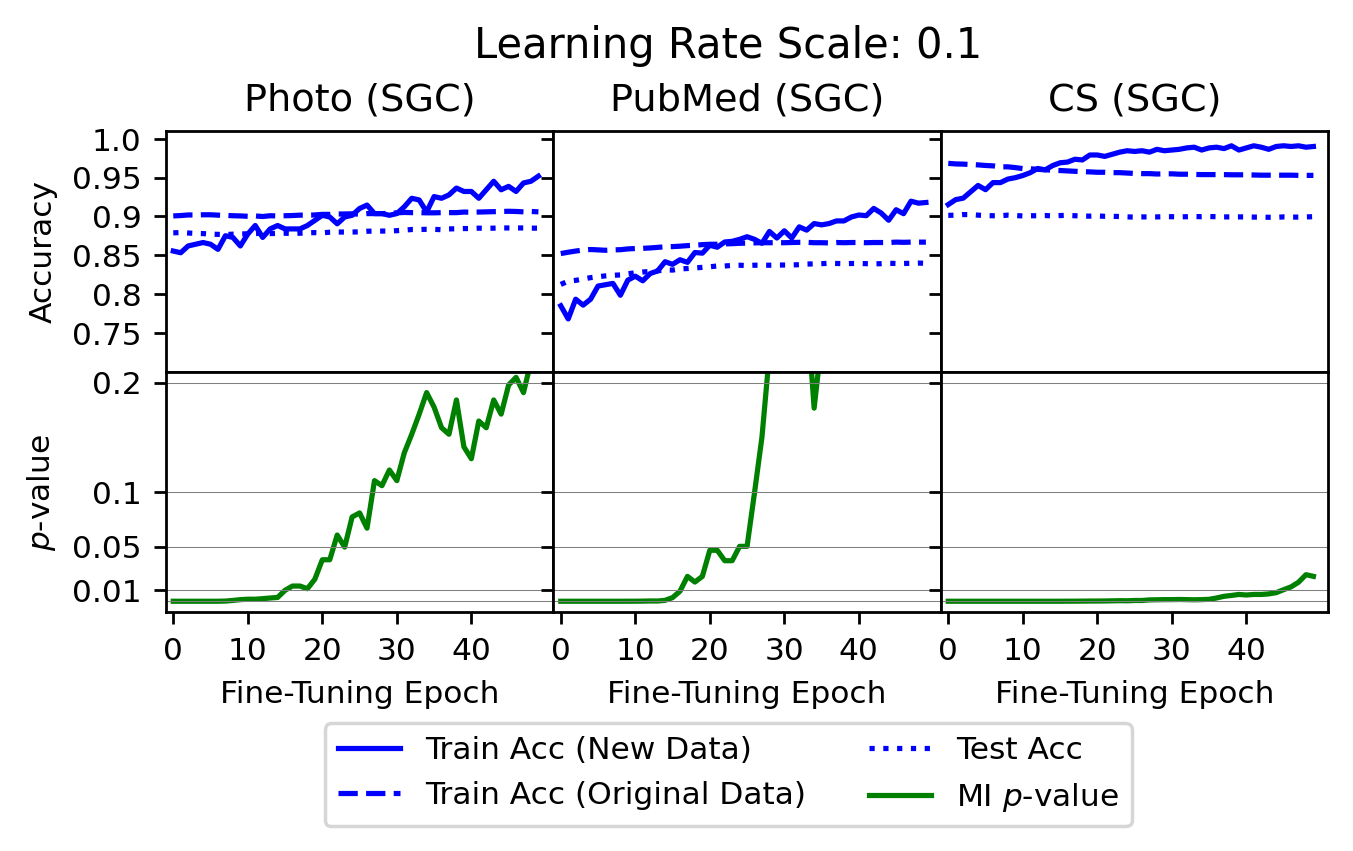

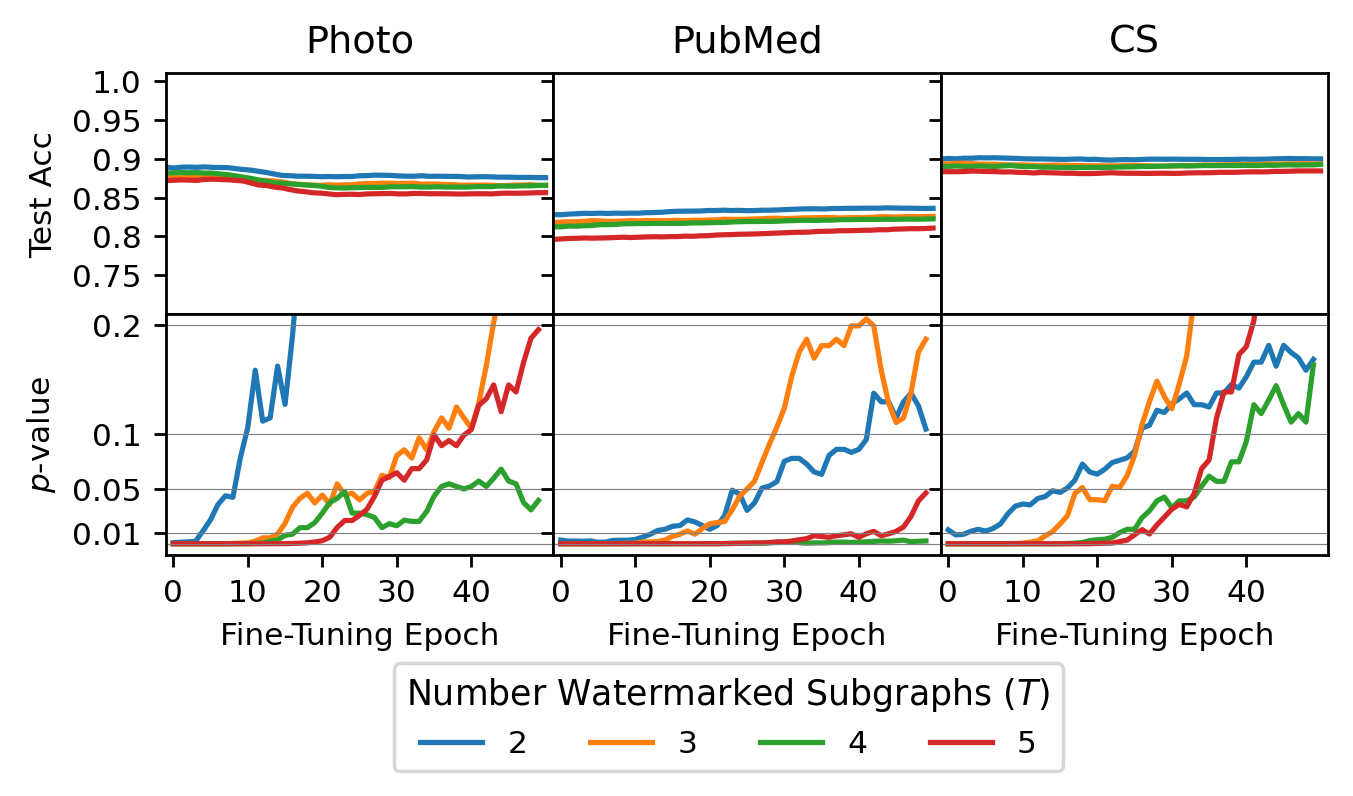

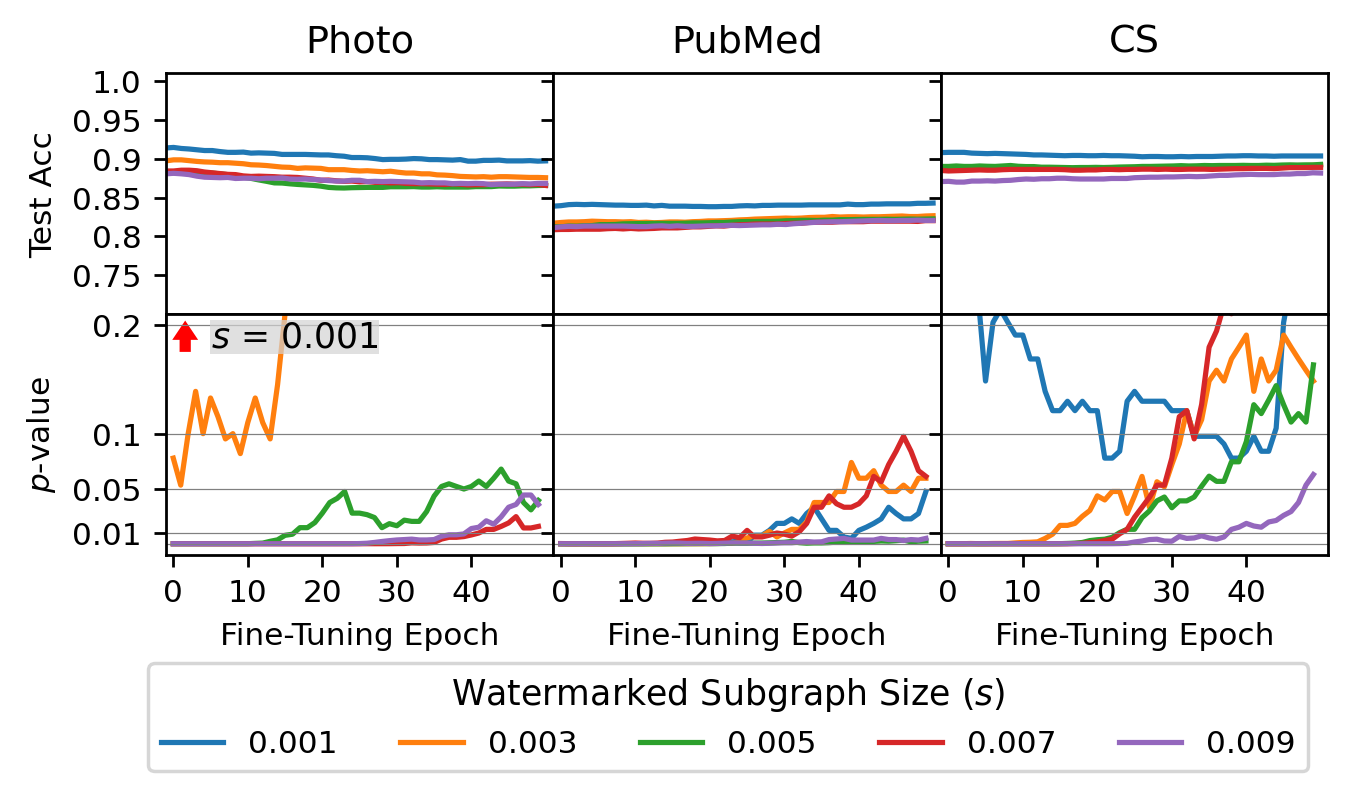

In [78]:
# arch = dataset_architecture_dict[dataset_name]
#xlabelsize=8, xticksize=8,yticksize=8,ylabelsize=8,bigtitlesize=13,smalltitlesize=11



def plot_all_datasets(dataset_architecture_dict, num_subgraphs, subgraph_size, task='prune',pruning_type='unstructured', arch='SAGE',exclude_title=False,
                              xrotation=45,xticksize=7,yticksize=7,xlabelsize=9,ylabelsize=9,bigtitlesize=13,smalltitlesize=11,legendsize=8, lr=None, lr_scale=None, seeds=[1,2,3,4]):
    if lr is not None:
        assert lr_scale is None
    if lr_scale is not None:
        assert lr is None

    num_cols = len(dataset_architecture_dict)
    fig = plt.figure(figsize=(6, 2.5))
    gs = gridspec.GridSpec(2, num_cols, figure=fig)
    for i, dataset_name in enumerate(dataset_architecture_dict.keys()):
        print(dataset_name,arch, num_subgraphs, subgraph_size)
        training_results_folder = f'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/{dataset_name}'
        architecture_folder = [os.path.join(training_results_folder,f) for f in os.listdir(training_results_folder) if f[0]!='.' and 'clf' not in f and 'watermark' not in f and 'KD' not in f and arch in f][0]
        print(('architecture_folder:',architecture_folder))
        model_folders = [f for f in os.listdir(architecture_folder) if f[0]!='.']
        print(f"looking for model with subgraph_size={subgraph_size} and num_subgraphs={num_subgraphs}")
        model_folder = [os.path.join(architecture_folder,f) for f in model_folders if parse_subgraph_size(f)==subgraph_size and parse_num_subgraphs_from_path(f)==num_subgraphs][0]
        col = i
        ax1 = fig.add_subplot(gs[0,col])
        ax2 = fig.add_subplot(gs[1,col])
        c = int(model_folder.split('numSubgraphs')[1].split('_')[0])
        confidence = 0.95
        if task=='prune':
            prune_rates, train_accs, val_accs, wmk_matches, target_matches_empirical, mu_natural_empirical, sigma_natural_empirical = gather_prune_stats(model_folder, confidence,pruning_type=pruning_type)
            prune_plot(prune_rates, train_accs, val_accs, wmk_matches, c, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, axs=[ax1,ax2],
                       xlabelsize=xlabelsize, xticksize=xticksize,yticksize=yticksize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,smalltitlesize=smalltitlesize)

        elif task=='fine_tune':
            epochs, wmk_matches, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, og_trn_accs, new_trn_accs, val_accs = gather_fine_tune_stats(model_folder, confidence, ignore_zeros=True, lr=lr, lr_scale=lr_scale, seeds=seeds)#, continuation=continuation,starting_epoch=starting_epoch)
            fine_tune_plot(dataset_name, epochs, wmk_matches, c, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, og_trn_accs, new_trn_accs, val_accs, model_folder, axs=[ax1, ax2],
                           xlabelsize=xlabelsize, xticksize=xticksize,yticksize=yticksize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,smalltitlesize=smalltitlesize)
            fig.suptitle(f'Learning Rate Scale: {lr_scale}',y=1.05)
            
        if task=='prune':
            if pruning_type=='unstructured':
                xticks = np.linspace(0,1,6)[:-1]
                xticklabels = [f'{v:.2f}' for v in xticks]
                x_lb,x_ub = -0.01,1.01
            elif pruning_type=='structured':
                xticks = np.linspace(0,0.5,6)[:-1]
                xticklabels = [f'{v:.2f}' for v in xticks]
                x_lb,x_ub = -0.01,0.501
        elif task=='fine_tune':
            xticks = xticklabels = [int(i) for i in np.linspace(0,50,6)[:-1]]
            x_lb,x_ub = -1,51

        ax1.set_title(f'Photo ({arch})' if dataset_name=='photo' else f'{dataset_name} ({arch})',fontsize=smalltitlesize)
        ax1.label_outer()
        ax2.label_outer()
        handles, labels = [],[]
        handles_0, labels_0 = ax1.get_legend_handles_labels()
        handles_1, labels_1 = ax2.get_legend_handles_labels()
        handles.extend(handles_0);  handles.extend(handles_1)
        labels.extend(labels_0);    labels.extend(labels_1)
        ax1.set_xticks(xticks)
        ax1.set_xlim(x_lb,x_ub)
        ax2.set_xticks(xticks)
        ax2.set_xticklabels(xticklabels,rotation=xrotation,fontsize=xticksize)
        ax2.set_xlim(x_lb,x_ub)

    if exclude_title==False:
        if task=='prune':
            if pruning_type=='unstructured':
                fig.suptitle(f'{pruning_type.capitalize()} Pruning',y=1.01,fontsize=bigtitlesize)
            else:
                fig.suptitle(f'Pruning',y=1.02,fontsize=bigtitlesize)
        elif task=='fine_tune':
            fig.suptitle('Fine Tuning',y=1.02,fontsize=bigtitlesize)
    task_descrip = f'{pruning_type}_pruning' if task=='prune' else 'fine_tuning'
    image_name = f'all_datasets_{arch}_{task_descrip}'
    ncols_legend=3 if task=='prune' else 2
    ylegend=-0.12 if task=='prune' else -0.15
    fig.legend(handles=handles,labels=labels,ncols=ncols_legend, loc='center', bbox_to_anchor=(0.5,ylegend),fontsize=legendsize)
    fig.subplots_adjust(wspace=0.0,hspace=0.0)

    plt.savefig(f'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/ICLR_photos/{image_name}.png',bbox_inches='tight',dpi=300)

dataset_architecture_dict = {'photo':'SAGE','PubMed':'SAGE','CS':'SAGE'}
arch='SAGE'
xrotation=0
xticksize=9
yticksize=9
xlabelsize=9
ylabelsize=9
bigtitlesize=13
smalltitlesize=11
legendsize=9
exclude_title=True
# plot_all_datasets(dataset_architecture_dict, 4, 0.005,'prune','unstructured',exclude_title=exclude_title, arch=arch,xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
#                                                                                         xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
#                                                                                         smalltitlesize=smalltitlesize,legendsize=legendsize)
# plot_all_datasets(dataset_architecture_dict, 4, 0.005,'prune','structured',exclude_title=exclude_title, arch=arch,xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
#                                                                                         xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
#                                                                                         smalltitlesize=smalltitlesize,legendsize=legendsize)
# plot_all_datasets(dataset_architecture_dict, 4, 0.005,'fine_tune',exclude_title=exclude_title, arch=arch,xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
                                                                                        # xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
                                                                                        # smalltitlesize=smalltitlesize,legendsize=legendsize, lr=None)
# plot_all_datasets(dataset_architecture_dict, 4, 0.005,'fine_tune',exclude_title=exclude_title, arch=arch,xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
                                                                                        # xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
                                                                                        # smalltitlesize=smalltitlesize,legendsize=legendsize, lr=0.0001)
plot_all_datasets(dataset_architecture_dict, 4, 0.005,'fine_tune',exclude_title=exclude_title, arch='SGC',xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
                                                                                        xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
                                                                                        smalltitlesize=smalltitlesize,legendsize=legendsize, lr_scale=0.1)
# plot_all_datasets(dataset_architecture_dict, 4, 0.005,'fine_tune',exclude_title=exclude_title, arch=arch,xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
#                                                                                         xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
#                                                                                         smalltitlesize=smalltitlesize,legendsize=legendsize, lr_scale=1)
# plot_all_datasets(dataset_architecture_dict, 4, 0.005,'fine_tune',exclude_title=exclude_title, arch=arch,xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
#                                                                                         xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
#                                                                                         smalltitlesize=smalltitlesize,legendsize=legendsize, lr_scale=10)

# plot_all_datasets_ablation(dataset_architecture_dict, 'num_subgraph','prune','structured',exclude_title=exclude_title, arch='SAGE',include_accs=True, xrota/tion=xrotation,xticksize=xticksize,yticksize=yticksize,
                                                                                        # xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
                                                                                        # smalltitlesize=smalltitlesize,legendsize=legendsize, seeds=[0,1,2])
plot_all_datasets_ablation(dataset_architecture_dict, 'num_subgraph','fine_tune',exclude_title=exclude_title, arch='SAGE',include_accs=True, xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
                                                                                        xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
                                                                                        smalltitlesize=smalltitlesize,legendsize=legendsize, seeds=None)
# plot_all_datasets_ablation(dataset_architecture_dict, 'subgraph_size','prune','structured',exclude_title=exclude_title, arch='SAGE',include_accs=True,  show_subgraph_sizes='odds',xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
#                                                                                         xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
#                                                                                         smalltitlesize=smalltitlesize,legendsize=legendsize, seeds=[0,1,2])

plot_all_datasets_ablation(dataset_architecture_dict, 'subgraph_size','fine_tune',exclude_title=exclude_title, arch='SAGE',include_accs=True, show_subgraph_sizes='odds',xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
                                                                                        xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
                                                                                        smalltitlesize=smalltitlesize,legendsize=legendsize, seeds=None)
# plot_all_datasets_ablation(dataset_architecture_dict, 'subgraph_size','prune',exclude_title=exclude_title, arch='SAGE',xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
#                                                                                         xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
#                                                                                         smalltitlesize=smalltitlesize,legendsize=legendsize)
# plot_all_datasets_ablation(dataset_architecture_dict, 'subgraph_size','fine_tune',exclude_title=exclude_title, arch='SAGE',xrotation=xrotation,xticksize=xticksize,yticksize=yticksize,
#                                                                                         xlabelsize=xlabelsize,ylabelsize=ylabelsize,bigtitlesize=bigtitlesize,
#                                                                                         smalltitlesize=smalltitlesize,legendsize=legendsize)

In [ ]:
t = torch.tensor([0,0,1,1,0,1,1,1,1,1])
w = torch.where(t==True)[0]


indices_permutation = torch.randperm(len(w))
proportion_as_int = int(np.floor(p*len(t)))
indices_to_use = indices_permutation[:proportion_as_int]
use = w[indices_to_use]
use

tensor([9])

100.0

In [ ]:
f = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/14.36pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.01_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_coefWmk100_pcgrad_regressionLambda0.1/seed0/node_classifier'

pickle.load(open(f,'rb'))

/Users/janedowner/miniforge3/envs/proj_2_env/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b)

Net(
  (convs): ModuleList(
    (0): SAGEConv(745, 256, aggr=mean)
    (1): SAGEConv(256, 256, aggr=mean)
    (2): SAGEConv(256, 8, aggr=mean)
  )
  (lin): Linear(in_features=520, out_features=8, bias=True)
)

In [ ]:
xxx = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/14.36pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.01_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_coefWmk100_pcgrad_regressionLambda0.1'
os.path.exists(xxx)

True

In [ ]:
'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/14.36pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.01_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_coefWmk100_pcgrad_regressionLambda0.1/seed3/results_fine_tune_lr_scale=1.0.txt'
'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim512_drop0.95_skipTrue/17.6pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.005_epochs200_coefWmk2.4_pcgrad_regressionLambda0.1/seed3/results_fine_tune_lr_scale=1.0.txt'


model_path: /Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/42.55pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs2_eps0.01_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.0002_epochs300_coefWmk100_pcgrad_regressionLambda0.1


TypeError: fine_tune_plot() got multiple values for argument 'axs'

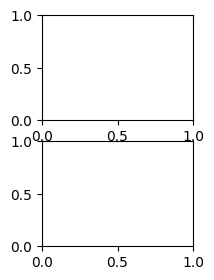

In [ ]:




def plot_all_fine_tune_in_grid(arch_path, subgraph_size=None):
    model_paths = [os.path.join(arch_path,f) for f in os.listdir(arch_path) if  f[0]!='.' and '.png' not in f and 'ignore' not in f]
    if subgraph_size is not None:
        model_paths = [m for m in model_paths if parse_subgraph_size(m)==subgraph_size]
    model_paths = sorted(model_paths, key=parse_num_subgraphs_from_path)

    num_cols = len(model_paths)
    fig = plt.figure(figsize=(9, 3))
    gs = gridspec.GridSpec(2, num_cols, figure=fig)

    for i, model_path in enumerate(model_paths):
        col = i
        ax1 = fig.add_subplot(gs[0,col])
        ax2 = fig.add_subplot(gs[1,col])
        print('model_path:',model_path)
        dataset_name = model_path.split('training_results')[1].split('/')[1].split('/')[0]
        c = int(model_path.split('numSubgraphs')[1].split('_')[0])
        confidence = 0.95
        epochs, wmk_matches, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, og_trn_accs, new_trn_accs, val_accs = gather_fine_tune_stats(model_path, confidence, ignore_zeros=True, seeds=seeds)#, continuation=continuation,starting_epoch=starting_epoch)
        fine_tune_plot(dataset_name, epochs, wmk_matches, c, confidence, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, og_trn_accs, new_trn_accs, val_accs, model_path, axs=[ax1, ax2])
        ax1.label_outer()
        ax1.set_title(f'{c} Subgraphs',y=0.8,fontsize=8)
        ax2.label_outer()

        handles, labels = [],[]
        handles_0, labels_0 = ax1.get_legend_handles_labels()
        handles_1, labels_1 = ax2.get_legend_handles_labels()
        handles.extend(handles_0);  handles.extend(handles_1)
        labels.extend(labels_0);    labels.extend(labels_1)


    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), ncol=4,fontsize=8)
    fig.suptitle(dataset_name.capitalize(),y=0.9,fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def plot_all_prune_in_grid(arch_path,pruning_type='structured', subgraph_size=None):
    model_paths = [os.path.join(arch_path,f) for f in os.listdir(arch_path) if  f[0]!='.' and '.png' not in f and 'ignore' not in f]
    if subgraph_size is not None:
        model_paths = [m for m in model_paths if parse_subgraph_size(m)==subgraph_size]
    model_paths = sorted(model_paths, key=parse_num_subgraphs_from_path)
    num_cols = len(model_paths)
    fig = plt.figure(figsize=(9, 3))
    print('num_cols:',num_cols)
    gs = gridspec.GridSpec(2, num_cols, figure=fig)

    for i, model_path in enumerate(model_paths):
        col = i
        ax1 = fig.add_subplot(gs[0,col])
        ax2 = fig.add_subplot(gs[1,col])
        print('model_path:',model_path)
        dataset_name = model_path.split('training_results')[1].split('/')[1].split('/')[0]
        c = int(model_path.split('numSubgraphs')[1].split('_')[0])
        confidence = 0.95
        prune_rates, train_accs, val_accs, wmk_matches, target_matches_empirical, mu_natural_empirical, sigma_natural_empirical = gather_prune_stats(model_path, confidence,pruning_type=pruning_type)
        prune_plot(prune_rates, train_accs, val_accs, wmk_matches, c, confidence, mu_natural_empirical, sigma_natural_empirical, target_matches_empirical, model_path, use_p_instead_of_count=True, axs=[ax1,ax2])

        ax1.label_outer()
        ax1.set_title(f'{c} Subgraphs',y=0.8,fontsize=8)
        ax2.label_outer()

        handles, labels = [],[]
        handles_0, labels_0 = ax1.get_legend_handles_labels()
        handles_1, labels_1 = ax2.get_legend_handles_labels()
        handles.extend(handles_0);  handles.extend(handles_1)
        labels.extend(labels_0);    labels.extend(labels_1)


    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), ncol=4,fontsize=8)
    fig.suptitle(dataset_name.capitalize(),y=0.9,fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue'
# folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue'
# folder='/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue'
# folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results_9_12/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue'
# folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue'
# folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue'
# folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSGC_elu_nLayers3_hDim256_drop0.1_skipTrue'
# folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSGC_elu_nLayers3_hDim512_drop0.8_skipTrue'
# folder = '/Users/janedowner/Desktop/Desktop/IDEAL/' + folder_
num_cols = len([f for f in os.listdir(folder) if f[0]!='.' and '.png' not in f and 'ignore' not in f])
plot_all_fine_tune_in_grid(folder, subgraph_size=0.005)
plot_all_prune_in_grid(folder,pruning_type='unstructured',subgraph_size=0.005)
plot_all_prune_in_grid(folder,pruning_type='structured',subgraph_size=0.005)




In [ ]:
l = 'Epoch:   0, L_clf = 0.134, train (test) acc = 0.956, val acc = 0.940, #_match_wmk w/wout 0s = (4822,508), confidence w/wout 0s = (1.000,0.876), #_match_un_wmk w/wout 0s = (4691,485), confidence w/wout 0s = (1.000,0.731)\n'
l.split('train (og) acc')#[1]#.split(',')

['Epoch:   0, L_clf = 0.134, train (test) acc = 0.956, val acc = 0.940, #_match_wmk w/wout 0s = (4822,508), confidence w/wout 0s = (1.000,0.876), #_match_un_wmk w/wout 0s = (4691,485), confidence w/wout 0s = (1.000,0.731)\n']

In [ ]:
full_path = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/8.46pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.001_epochs90_coefWmk20_pcgrad_regressionLambda0.1/seed0/results_fine_tune.txt'
lines = open(full_path,'r').readlines()
lines


FileNotFoundError: [Errno 2] No such file or directory: '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/8.46pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.001_epochs90_coefWmk20_pcgrad_regressionLambda0.1/seed0/results_fine_tune.txt'

In [ ]:
lines = ['Prune rate: 0.0\n', 'Trn acc: 0.948  Val acc: 0.931  Avg wmk match rate: 80.161  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3889,306)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3697,178)  Confidence w/wout 0s: (1.0,0.571)Prune rate: 0.1\n', 'Trn acc: 0.947  Val acc: 0.93  Avg wmk match rate: 80.161  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3888,305)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3697,178)  Confidence w/wout 0s: (1.0,0.571)Prune rate: 0.2\n', 'Trn acc: 0.947  Val acc: 0.931  Avg wmk match rate: 80.046  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3894,311)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3697,178)  Confidence w/wout 0s: (1.0,0.571)Prune rate: 0.3\n', 'Trn acc: 0.948  Val acc: 0.931  Avg wmk match rate: 80.161  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3885,302)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3701,182)  Confidence w/wout 0s: (1.0,0.66)Prune rate: 0.4\n', 'Trn acc: 0.948  Val acc: 0.931  Avg wmk match rate: 80.392  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3893,310)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3701,182)  Confidence w/wout 0s: (1.0,0.66)Prune rate: 0.5\n', 'Trn acc: 0.948  Val acc: 0.931  Avg wmk match rate: 80.507  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3889,306)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3696,177)  Confidence w/wout 0s: (1.0,0.548)Prune rate: 0.6\n', 'Trn acc: 0.948  Val acc: 0.93  Avg wmk match rate: 79.354  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3885,302)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3685,166)  Confidence w/wout 0s: (1.0,0.303)Prune rate: 0.7\n', 'Trn acc: 0.948  Val acc: 0.926  Avg wmk match rate: 77.855  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3866,283)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3687,168)  Confidence w/wout 0s: (1.0,0.344)Prune rate: 0.8\n', 'Trn acc: 0.944  Val acc: 0.914  Avg wmk match rate: 73.587  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3842,259)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3698,179)  Confidence w/wout 0s: (1.0,0.594)Prune rate: 0.9\n', 'Trn acc: 0.894  Val acc: 0.835  Avg wmk match rate: 66.897  Target # matches: 215.0  \n', '# Matches Wmk w/wout 0s: (3833,250)  Confidence w/wout 0s: (1.0,1.0)  # Matches Not Wmk w/wout 0s: (3718,199)  Confidence w/wout 0s: (1.0,0.919)']
prune_rates = [float(l_.split()[0]) for l_ in [l for l in ''.join(lines).split('Prune rate: ') if len(l)>0]]
trn_accs = [float(l.split('Trn acc: ')[1].split()[0]) for l in lines[1::2]]
val_accs = [float(l.split('Val acc: ')[1].split()[0]) for l in lines[1::2]]
wmk_matches_w_zeros = [int(l.split('# Matches Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[0]) for l in [line for line in lines[0::2] if "# Matches" in line]]
wmk_matches_wout_zeros = [int(l.split('# Matches Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[1]) for l in [line for line in lines[0::2] if "# Matches" in line]]
un_wmk_matches_w_zeros = [int(l.split('# Matches Not Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[0]) for l in [line for line in lines[0::2] if "# Matches" in line]]
un_wmk_matches_wout_zeros = [int(l.split('# Matches Not Wmk w/wout 0s:')[1].split()[0][1:-1].split(',')[1]) for l in [line for line in lines[0::2] if "# Matches" in line]]
target_matches_predicted = int(float(''.join(lines).split('Target # matches:')[1].split()[0]))


num_subgraphs = int(model_path.split('/')[-1].split('numSubgraphs')[1].split('_')[0])
mu_natural_predicted, sigma_natural_predicted = get_natural_match_distribution(data.x.shape[1], len(num_subgraphs))
print(prune_rates)
print(trn_accs)
print(val_accs)
print(target_matches_predicted)
print(wmk_matches_w_zeros)
print(wmk_matches_wout_zeros)
print(un_wmk_matches_w_zeros)
print(un_wmk_matches_wout_zeros)

NameError: name 'data' is not defined

In [ ]:
model_path = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/4.25pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs3_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_pcgrad_regressionLambda0.1'


In [ ]:
gather_random_subgraphs_not_watermarked(data, dataset_name, 
                                        subgraph_method_choices = ['random'],
                                        max_degrees_choices=[20,50,100], 
                                        frac_choices = [0.001,0.004,0.005,0.01], 
                                        restart_prob_choices = [0,0.1,0.2], 
                                        nHops_choices=[1,2,3],
                                        overrule_size_info=False, 
                                        explicit_size_choice=10, 
                                        seed=0):

SyntaxError: invalid syntax (510627744.py, line 9)

In [ ]:
n_features = config.dataset_attributes[dataset_name]['num_features']
mu_natural, sigma_natural = get_natural_match_distribution(n_features, c)
#z_score_dict = {0.9:1.645, 0.95:1.96, 0.99:2.576, 0.999:3.2905}
#z_t = z_score_dict[0.99]
z_t = z_t = norm.ppf(0.99)
t = mu_natural +z_t*sigma_natural


# t evaluates to 63.58211148205211


z_score = (59 - mu_natural)/sigma_natural
p_value = stats.norm.cdf(z_score)
p_value
# p_value evaluates to 0.995002467684265
# p_value evaluates to 0.9958455089913387

NameError: name 'c' is not defined

In [ ]:
p='/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/2.34pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1/seed4/config_dict'
xxx = pickle.load(open(p,'rb'))
xxx

FileNotFoundError: [Errno 2] No such file or directory: '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/2.34pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1/seed4/config_dict'

In [ ]:



model_folder = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/17.45pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs2_eps0.1_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1'

fine_tune_plot(model_folder)

TypeError: fine_tune_plot() missing 12 required positional arguments: 'epochs', 'wmk_matches', 'un_wmk_matches', 'c', 'confidence', 'mu_natural', 'sigma_natural', 'target_matches', 'og_trn_accs', 'new_trn_accs', 'val_accs', and 'model_path'

In [ ]:
wmk_matches

NameError: name 'wmk_matches' is not defined

In [ ]:
bs = torch.tensor([[1,2,3,4],[1,1,1,1],[1,1,1,1],[1,2,2,2]])
count_matches(bs)

1

In [ ]:
dataset_name='computers'
get_presets(dataset,dataset_name)

config.watermark_kwargs['percent_of_features_to_watermark']=6.91
config.subgraph_kwargs['numSubgraphs']=4
config.seed=4

#path='/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/4.82pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs5_eps0.01_nodeDropP0.35_nodeMixUp40_edgeDrop0.4_lr0.002_epochs150_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4'


config_dict = {'node_classifier_kwargs':config.node_classifier_kwargs,
            'optimization_kwargs':config.optimization_kwargs,
            'watermark_kwargs':config.watermark_kwargs,
            'subgraph_kwargs':config.subgraph_kwargs,
            'regression_kwargs':config.regression_kwargs,
            'watermark_loss_kwargs':config.watermark_loss_kwargs,
            'augment_kwargs':config.augment_kwargs,
            'seed':config.seed}

results_folder_name = get_results_folder_name(dataset_name)
os.path.exists(results_folder_name)

with open(os.path.join(results_folder_name,'config_dict'),'wb') as f:
    pickle.dump(config_dict,f)



NameError: name 'dataset' is not defined

In [ ]:
print('/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/4.82pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs5_eps0.01_nodeDropP0.35_nodeMixUp40_edgeDrop0.4_lr0.002_epochs150_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4')
print(results_folder_name)

/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/4.82pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs5_eps0.01_nodeDropP0.35_nodeMixUp40_edgeDrop0.4_lr0.002_epochs150_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4


NameError: name 'results_folder_name' is not defined

In [ ]:
# d = {'arch': 'GCN',
#  'activation': 'elu',
#  'nLayers': 3,
#  'hDim': 256,
#  'dropout': 0.1,
#  'dropout_subgraphs': 0,
#  'skip_connections': True,
#  'heads_1': 8,
#  'heads_2': 1,
#  'inDim': 745,
#  'outDim': 8}

# arch = 'GAT'#d['arch']
# act = d['activation']
# nLayers=d['nLayers']
# hDim=d['hDim']
# dropout=d['dropout']
# skip=d['skip_connections']
# heads_1=d['heads_1']
# heads_2=d['heads_2']


# model_tag = f'arch{arch}_{act}_nLayers{nLayers}_hDim{hDim}_drop{dropout}_skip{skip}'
# if arch == 'GAT':
#     heads_1 = 1#node_classifier_kwargs['heads_1']
#     heads_2 = 8#node_classifier_kwargs['heads_2']
#     model_tag += f'_heads_{heads_1}_{heads_2}'


In [ ]:
# model_tag_split = model_tag.split('_')
# arch = model_tag_split[0][4:]
# act = model_tag_split[1]
# nLayers = int(model_tag_split[2][7:])
# hDim = int(model_tag_split[3][4:])
# dropout = float(model_tag_split[4][4:])
# skip = bool(model_tag_split[5][4:])
# if arch=='GAT':
#     heads_1 = int(model_tag_split[-2])
#     heads_2 = int(model_tag_split[-1])


# # print(arch,act,nLayers,hDim,dropout,skip)
# # if arch=='GAT':
#     # print(heads_1,heads_2)
# # model_kwargs = {'heads_1':0,'heads_2':0}
# model_kwargs = {**node_classifier_kwargs}#'arch':arch,'inDim':data.num_features,'hDim':hDim,'outDim':dataset_attributes[dataset_name]['num_classes'],'dropout':dropout,'activation':act,'nLayers':nLayers,'skip_connections':skip}#
# if arch=='GAT':
#     model_kwargs['heads_1']=heads_1
#     model_kwargs['heads_2']=heads_2
# else:
#     model_kwargs['heads_1']=0
#     model_kwargs['heads_2']=0

# gnn = Net(**model_kwargs)



In [ ]:


# # Assume `model` is your trained GNN model
# prune.l1_unstructured(model.conv1, name='weight', amount=0.3)
# prune.l1_unstructured(model.conv2, name='weight', amount=0.3)

# # Optionally make pruning permanent
# prune.remove(model.conv1, 'weight')
# prune.remove(model.conv2, 'weight')

In [ ]:
#node_classifier
#model.conv1.reset_parameters()
import pickle
import os
from   pcgrad.pcgrad import PCGrad
import torch
import torch.optim as optim
import torch.nn.utils.prune as prune

def get_node_classifier_and_optimizer_and_subgraph_dict_for_further_processing(model_path):
    node_classifier = pickle.load(open(os.path.join(model_path,'node_classifier'),'rb'))
    config_dict = pickle.load(open(os.path.join(model_path,'config_dict'),'rb'))
    subgraph_dict = pickle.load(open(os.path.join(model_path,'subgraph_dict'),'rb'))
    optimization_kwargs = config_dict['optimization_kwargs']
    params_ = list(node_classifier.parameters())
    if optimization_kwargs['use_sam']==True:
        optimizer = SAM(params_, optim.SGD, lr=optimization_kwargs['lr'], momentum=optimization_kwargs['sam_momentum'], rho = optimization_kwargs['sam_rho'])
    else:
        optimizer = optim.Adam(params_, lr=optimization_kwargs['lr'])
    if optimization_kwargs['use_pcgrad']==True:
        optimizer = PCGrad(optimizer)
    return node_classifier, optimizer, subgraph_dict

def calculate_sparsity(model):
    total_params = 0
    total_zero_params = 0
    for name, module in model.named_modules():
        if isinstance(module, SAGEConv):
            weight_tensor = module.lin_l.weight
            total_params += weight_tensor.numel()
            total_zero_params += (weight_tensor == 0).sum().item()
            if hasattr(module, 'lin_r'):
                weight_tensor = module.lin_r.weight
                total_params += weight_tensor.numel()
                total_zero_params += (weight_tensor == 0).sum().item()
        elif isinstance(module, GCNConv):
            if hasattr(module, 'lin'):  # Check if the internal linear layer exists
                weight_tensor = module.lin.weight
                total_params += weight_tensor.numel()
                total_zero_params += (weight_tensor == 0).sum().item()
        else:
            if hasattr(module, 'weight'):
                weight_tensor = module.weight.data
                total_params += weight_tensor.numel()
                total_zero_params += (weight_tensor == 0).sum().item()
            elif hasattr(module, 'weight_orig'):
                weight_tensor = module.weight_orig.data
                total_params += weight_tensor.numel()
                total_zero_params += (module.weight_mask == 0).sum().item()
    
    sparsity = total_zero_params / total_params
    print(f"Model Sparsity: {sparsity:.2%}")
    return sparsity

def apply_pruning(node_classifier,amount=0.3):
    for name, module in node_classifier.named_modules():
        if isinstance(module, SAGEConv):
            prune.l1_unstructured(module.lin_l, name='weight', amount=amount)
            if hasattr(module, 'lin_r'):
                prune.l1_unstructured(module.lin_r, name='weight', amount=amount)
        elif isinstance(module, GCNConv):
            if hasattr(module, 'lin'):  # Check if the internal linear layer exists
                prune.l1_unstructured(module.lin, name='weight', amount=0.3)
            else:
                print(f"{name} does not have an internal 'lin' attribute with 'weight'.")
        elif isinstance(module, (GATConv, GCNConv, GraphConv)):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return node_classifier

def test_node_classifier(node_classifier, data, subgraph_dict, watermark_loss_kwargs, optimization_kwargs, regression_kwargs, node_classifier_kwargs):

    node_aug, edge_aug  = collect_augmentations()
    sacrifice_method    = optimization_kwargs['sacrifice_kwargs']['method']
    beta_weights        = torch.ones(len(subgraph_dict),data.num_features)     
    #
    all_subgraph_indices = []
    for sig in subgraph_dict.keys():
        nodeIndices = subgraph_dict[sig]['nodeIndices'].tolist()
        all_subgraph_indices += nodeIndices
    #
    all_subgraph_indices    = torch.tensor(all_subgraph_indices)
    train_nodes_to_consider = torch.where(get_train_nodes_to_consider(data, all_subgraph_indices, sacrifice_method, data.x.shape[0])==True)[0]
    edge_index, x, y        = augment_data(data, node_aug, edge_aug, train_nodes_to_consider, all_subgraph_indices)

    log_logits   = node_classifier(x, edge_index, node_classifier_kwargs['dropout'])
    probas       = log_logits.clone().exp()
    probas_dict  = separate_forward_passes_per_subgraph(subgraph_dict, node_classifier)

    acc_trn = accuracy(log_logits[data.train_mask], data.y[data.train_mask])
    acc_val = accuracy(log_logits[data.val_mask],   data.y[data.val_mask])


    raw_betas = []
    match_rates = []
    for s, sig in enumerate(subgraph_dict.keys()):
        beta_weights_ = beta_weights[s]
        _, this_percent_match, _, this_raw_beta = get_watermark_performance(probas, probas_dict,subgraph_dict,sig,ignore_zeros_from_subgraphs=False, 
                                                                                                                debug=False,beta_weights=beta_weights_,similar_subgraph=False,
                                                                                                                watermark_loss_kwargs=watermark_loss_kwargs,
                                                                                                                regression_kwargs=regression_kwargs,
                                                                                                                optimization_kwargs=optimization_kwargs)
        raw_betas.append(this_raw_beta)
        match_rates.append(this_percent_match)

    bs = torch.vstack(raw_betas)
    observed_match_count = count_matches(torch.vstack(raw_betas))
    mu_natural, sigma_natural = get_natural_match_distribution(data.x.shape[1], len(subgraph_dict))
    observed_matches_confidence = get_confidence_observed_matches(observed_match_count, mu_natural, sigma_natural)

    return match_rates, raw_betas, acc_trn, acc_val, observed_match_count, observed_matches_confidence



from scipy.stats import norm

def get_natural_match_distribution(n_features, c):
    p_natural_match = 2*(0.5**(c))
    mu_natural = p_natural_match*n_features
    var_natural = n_features*p_natural_match*(1-p_natural_match)
    sigma_natural = np.sqrt(var_natural)
    return mu_natural, sigma_natural

def get_confidence_observed_matches(observed_matches, mu_natural, sigma_natural):
    z_score = (observed_matches - mu_natural) / sigma_natural
    one_tail_confidence_level = norm.cdf(z_score)
    return one_tail_confidence_level
# get_confidence_existing_matches(data, c)

    # p_natural_match = 2*(0.5**(c))
    # n_features = data.x.shape[1]
    # print('n_features:',n_features)
    # mu_natural = p_natural_match*n_features
    # print('mu_natural:',mu_natural)
    # var_natural = n_features*p_natural_match*(1-p_natural_match)
    # sigma_natural = np.sqrt(var_natural)




In [ ]:
# pubmed_model_paths = [
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/6.0pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs5_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs200_coefWmk70_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/8.6pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs200_coefWmk70_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/12.6pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs3_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs200_coefWmk70_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/20.8pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs2_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs200_coefWmk70_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4'
#  ]

# photo_model_paths = [
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/4.83pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs5_eps0.1_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/7.11pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/10.47pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs3_eps0.1_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/17.45pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs2_eps0.1_nodeDropP0.3_nodeMixUp1_nodeFeatMask0.3_edgeDrop0.3_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4'
# ]

# CS_model_paths = [
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/1.62pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs5_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/2.34pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/3.56pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs3_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/6.07pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs2_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4'
# ]

# computers_model_paths = [
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/4.82pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs5_eps0.01_nodeDropP0.35_nodeMixUp40_edgeDrop0.4_lr0.002_epochs150_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/6.91pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs4_eps0.01_nodeDropP0.35_nodeMixUp40_edgeDrop0.4_lr0.002_epochs150_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/10.3pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs3_eps0.01_nodeDropP0.35_nodeMixUp40_edgeDrop0.4_lr0.002_epochs150_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4',
#     '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue/17.34pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs2_eps0.01_nodeDropP0.35_nodeMixUp40_edgeDrop0.4_lr0.002_epochs150_coefWmk20_sacrifice1subNodes_pcgrad_regressionLambda0.1_seed4'
# ]

computers_root_path = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/computers/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue'
photo_root_path = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/photo/archGCN_elu_nLayers3_hDim256_drop0.1_skipTrue'
CS_root_path = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue'
PubMed_root_path = '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/PubMed/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue'

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
model_path

'/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results/CS/archSAGE_elu_nLayers3_hDim256_drop0.1_skipTrue/4.25pctMostRepIndices_random_sub_size_as_fraction0.005_numSubgraphs3_eps0.1_nodeDropP0.1_nodeMixUp5_edgeDrop0.1_lr0.001_epochs90_coefWmk20_pcgrad_regressionLambda0.1'

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


# for dataset_name in ['PubMed','photo','computers]:
for dataset_name in ['PubMed']:
    print(dataset_name)
    get_presets(dataset,dataset_name)

    if dataset_attributes[dataset_name]['single_or_multi_graph']=='single':
        dataset = prep_data(dataset_name=dataset_name, location='default', batch_size='default', transform_list='default',
                            train_val_test_split=[0.9,0.05,0.05])
        graph_to_watermark = data = dataset[0]
    elif dataset_attributes[dataset_name]['single_or_multi_graph']=='multi':
        [train_dataset, val_dataset, test_dataset], [train_loader, val_loader, test_loader] = prep_data(dataset_name=dataset_name, location='default', 
                                                                                                        batch_size='default', transform_list='default',
                                                                                                                                train_val_test_split=[0.9,0.05,0.05])
        graph_to_watermark = train_dataset[0]


    if dataset_name=='photo':
        root_path=photo_root_path
        model_paths = [os.path.join(root_path,p) for p in os.listdir(root_path) if p[0]!='.']
    elif dataset_name=='computers':
        root_path=computers_root_path
        model_paths = [os.path.join(root_path,p) for p in os.listdir(root_path) if p[0]!='.']
    elif dataset_name=='CS':
        root_path=CS_root_path
        model_paths = [os.path.join(root_path,p) for p in os.listdir(root_path) if p[0]!='.']
    elif dataset_name=='PubMed':
        root_path=PubMed_root_path
        model_paths = [os.path.join(root_path,p) for p in os.listdir(root_path) if p[0]!='.']

    for model_path in model_paths:
        print(model_path)
        print()
        config_dict = pickle.load(open(os.path.join(model_path,'config_dict'),'rb'))
        watermark_loss_kwargs = config_dict['watermark_loss_kwargs']
        optimization_kwargs = config_dict['optimization_kwargs']
        regression_kwargs = config_dict['regression_kwargs']
        node_classifier_kwargs = config_dict['node_classifier_kwargs']


        mean_match_rates = []
        sparsities = []

        node_classifier, optimizer, subgraph_dict = get_node_classifier_and_optimizer_and_subgraph_dict_for_further_processing(model_path)
        num_subgraphs = len(subgraph_dict)
        for amount in np.linspace(0,1,11):
            apply_pruning(node_classifier,amount=amount)
            _ = calculate_sparsity(node_classifier)


            match_rates, raw_betas = test_node_classifier(node_classifier, data, subgraph_dict, watermark_loss_kwargs, optimization_kwargs, regression_kwargs, node_classifier_kwargs)
            print('Mean Watermark match rate:',np.mean(match_rates))
            mean_match_rates.append(np.mean(match_rates))
            sparsities.append(amount)
            print()
        plt.plot(sparsities,mean_match_rates, label=str(num_subgraphs) + ' subgraphs')
    plt.xlabel('Pruning Sparsity')
    plt.ylabel('Average Watermark Match Rate')
    plt.title(f'Watermark Match Rate vs. Pruning Strength -- {dataset_name.title()}')
    plt.legend()
    plt.show()
    plt.savefig('/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/training_results')
    plt.close()


PubMed


NameError: name 'dataset' is not defined

In [ ]:
'abc def'.title()

'Abc Def'

In [ ]:
# import os
# import config
# import pickle


# config.watermark_kwargs['percent_of_features_to_watermark']=20.8
# config.subgraph_kwargs['numSubgraphs']=2
# config.seed=4


# config_dict = {'node_classifier_kwargs':config.node_classifier_kwargs,
#             'optimization_kwargs':config.optimization_kwargs,
#             'watermark_kwargs':config.watermark_kwargs,
#             'subgraph_kwargs':config.subgraph_kwargs,
#             'regression_kwargs':config.regression_kwargs,
#             'watermark_loss_kwargs':config.watermark_loss_kwargs,
#             'augment_kwargs':config.augment_kwargs,
#             'seed':config.seed}

# results_folder_name = get_results_folder_name(dataset_name)
# os.path.exists(results_folder_name)



In [ ]:
# with open(os.path.join(results_folder_name,'config_dict'),'wb') as f:
#     pickle.dump(config_dict,f)
